In [2]:
get_ipython().magic('matplotlib inline')
get_ipython().magic('config InlineBackend.figure_format = "retina"')

import matplotlib.pyplot as pl

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import os
import sys
from collections import OrderedDict
import numpy as np
import pandas as pd
from scipy import stats
from configobj import ConfigObj
from astropy import constants as c
from astropy import units as u
import pprint

import limbdark

pp = pprint.PrettyPrinter(indent=2)

def map_int(x):
    return list(map(int, x))

def map_float(x):
    return list(map(float, x))

sys.path.append('..')
from transitfit import TransitFit
from transitfit.util import mad_outliers, get_init_params, u_to_q, rho, bin_data

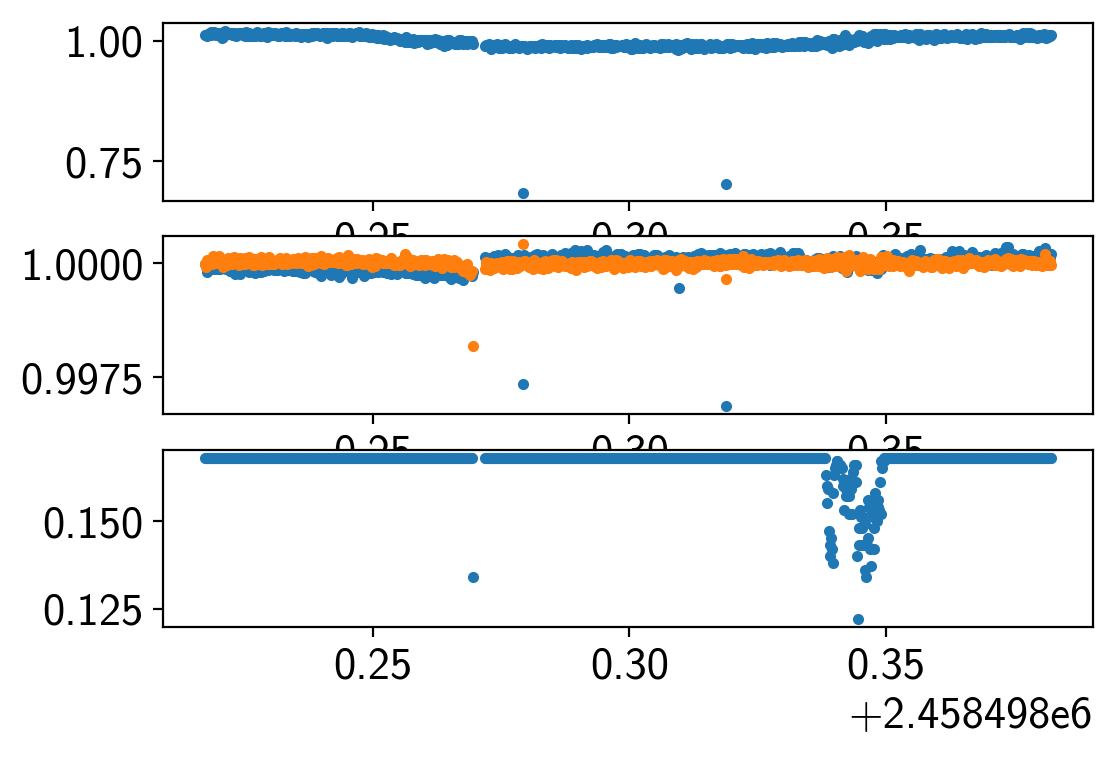

In [4]:
fp = '../data/LC_457.95000_428.84000.txt'
df = pd.read_table(fp, delim_whitespace=True, names='t f x y peak'.split())

time, flux, cenx, ceny, peak = df.values.T

time += 2400000.5
flux /= np.median(flux)

fig, axs = pl.subplots(3, 1)
axs[0].plot(time, flux, '.')
axs[1].plot(time, cenx/cenx.mean(), '.')
axs[1].plot(time, ceny/ceny.mean(), '.')
axs[2].plot(time, peak, '.')

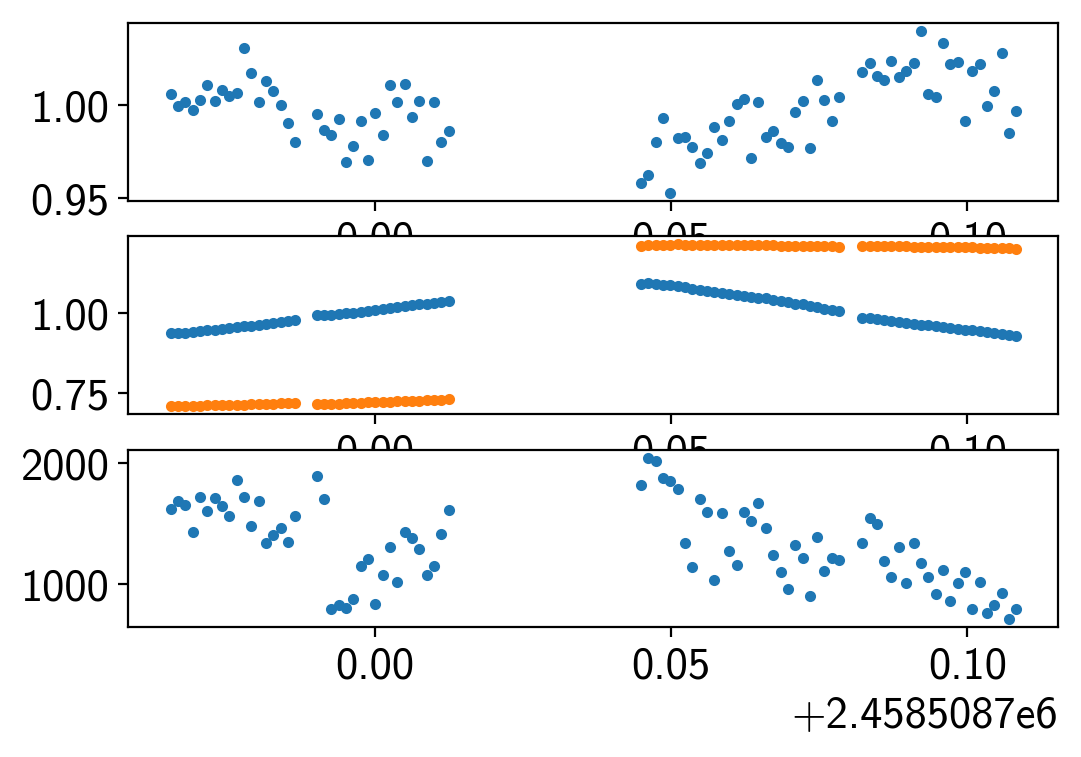

In [5]:
fp = '../data/Cat_129.17837_19.17388_1_1.txt'
df = pd.read_table(fp, delim_whitespace=True, names='t f x y peak'.split())

time, flux, cenx, ceny, peak = df.values.T

time += 2400000.5
flux /= np.median(flux)

fig, axs = pl.subplots(3, 1)
axs[0].plot(time, flux, '.')
axs[1].plot(time, cenx/cenx.mean(), '.')
axs[1].plot(time, ceny/ceny.mean(), '.')
axs[2].plot(time, peak, '.')

In [6]:
datasets = OrderedDict()

Ndata raw: 1099
Ndata clipped: 2
Ndata final: 118


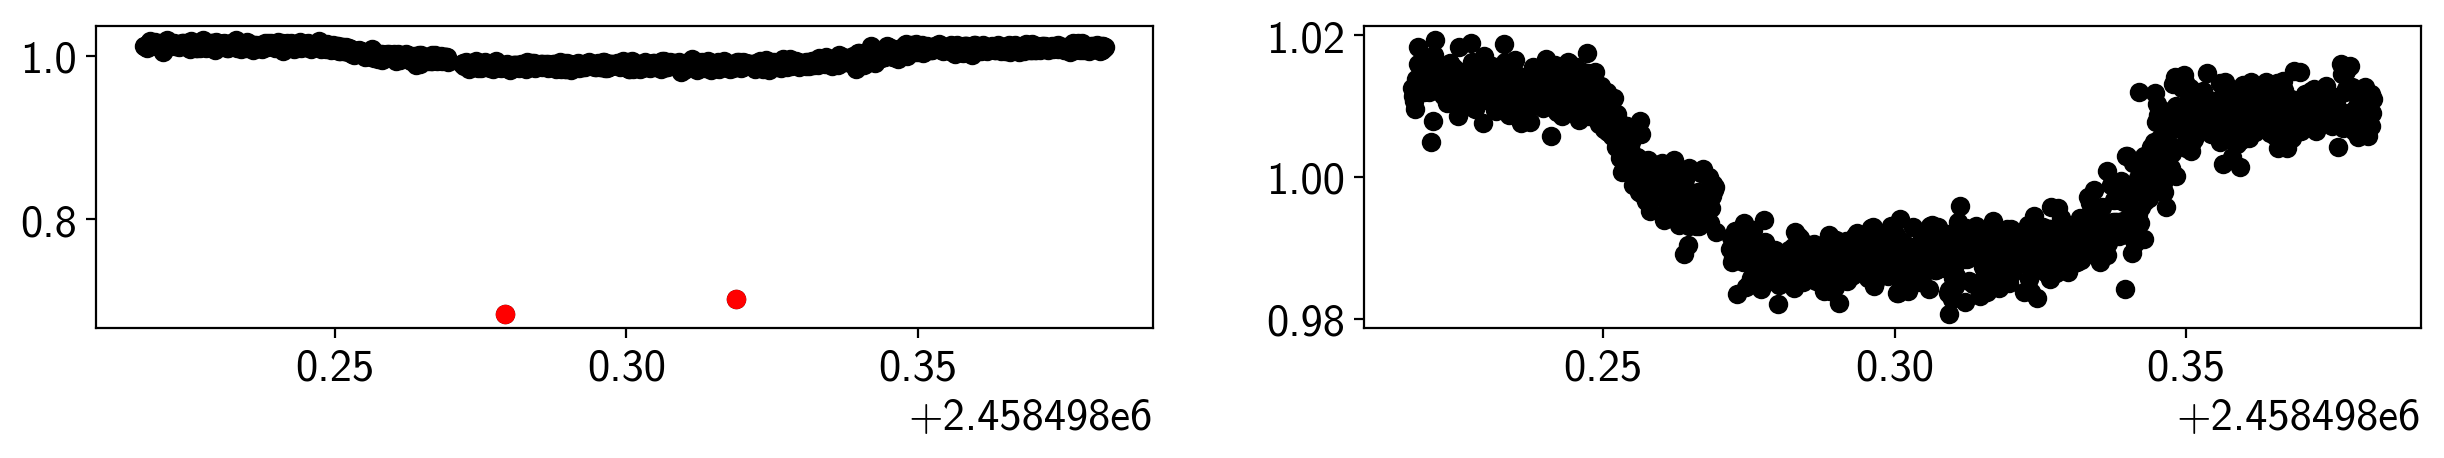

In [7]:
#################################
fp = '../data/LC_457.95000_428.84000.txt'
band = 'r'
t_range = None
binsize_min = 2

df = pd.read_table(fp, delim_whitespace=True, names='t f x y peak'.split()).dropna()
print("Ndata raw: {}".format(df.shape[0]))
time, flux, cenx, ceny, peak = df.values.T
time, flux = df['t f'.split()].values.T
time += 2400000.5
flux /= np.median(flux)

aux = np.c_[
    np.ones_like(time),
    time-time.min(), 
    (time-time.min())**2, 
    cenx/cenx.mean(), 
    ceny/ceny.mean(), 
#     peak/peak.mean()
]
#################################

fig, axs = pl.subplots(1, 2, figsize=(15,2))

ax = axs[0]
ax.plot(time, flux, marker='o', linestyle='none', color='k')

idx = mad_outliers(flux)
print("Ndata clipped: {}".format(idx.sum()))
ax.plot(time[idx], flux[idx], marker='o', linestyle='none', color='r')
t, f, aux = time[~idx], flux[~idx], aux[~idx]

data = np.c_[t, f, aux]

if binsize_min is not None:
    data = bin_data(data, binsize_min)

datasets[band] = data
print("Ndata final: {}".format(data.shape[0]))

if t_range is not None:
    t_min, t_max = t_range
    t = datasets[band][:,0]
    idx = (t > t_min) & (t < t_max)
    datasets[band] = datasets[band][idx]
    ax.axvline(t_min, color='b')
    ax.axvline(t_max, color='b')

ax = axs[1]
ax.plot(t, f, marker='o', linestyle='none', color='k')

Ndata raw: 87
Ndata clipped: 0
Ndata final: 77


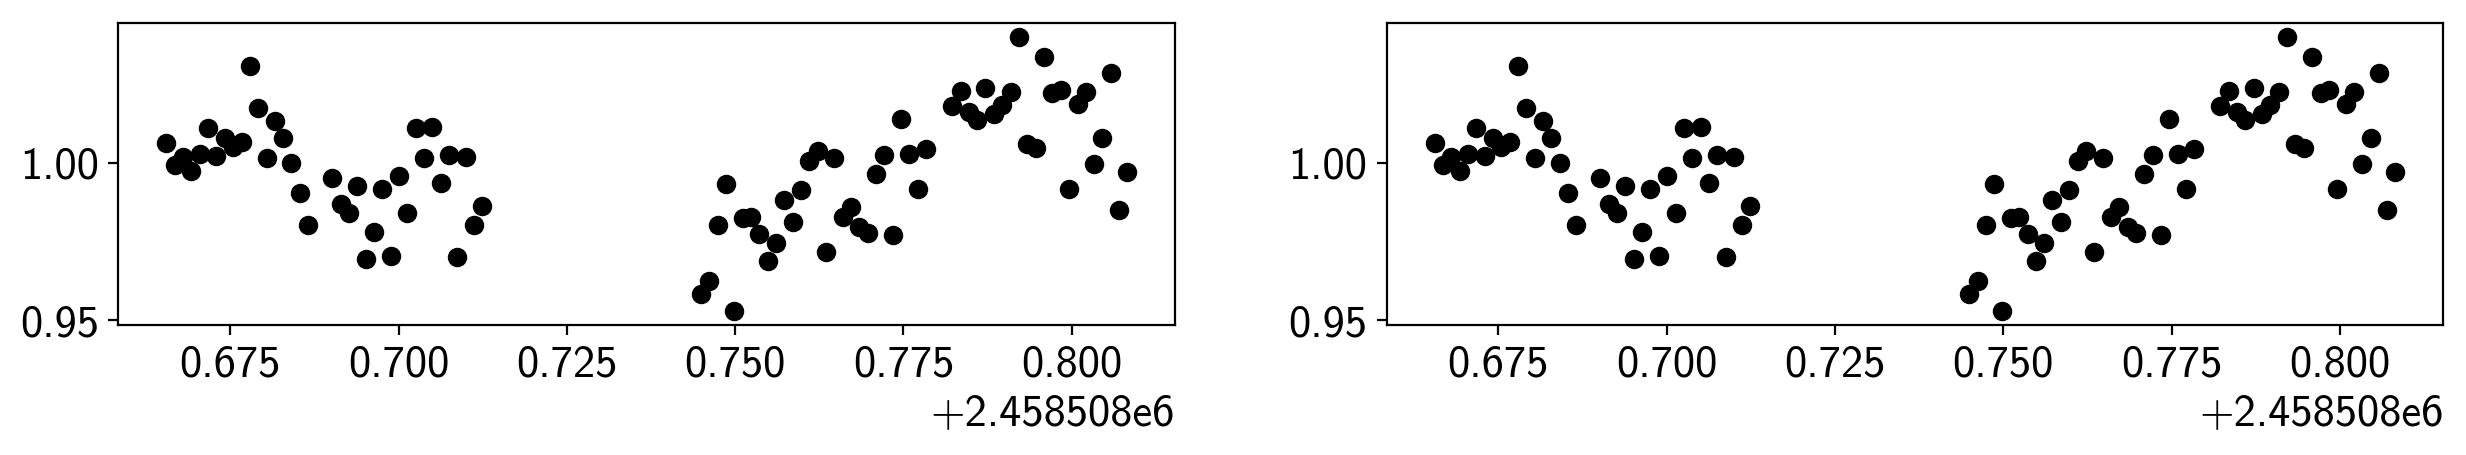

In [8]:
#################################
fp = '../data/Cat_129.17837_19.17388_1_1.txt'
band = 'V'
t_range = None
binsize_min = 2

df = pd.read_table(fp, delim_whitespace=True, names='t f x y peak'.split()).dropna()
print("Ndata raw: {}".format(df.shape[0]))
time, flux, cenx, ceny, peak = df.values.T
time, flux = df['t f'.split()].values.T
time += 2400000.5
flux /= np.median(flux)

aux = np.c_[
    np.ones_like(time),
    time-time.min(), 
#     (time-time.min())**2, 
#     cenx/cenx.mean(), 
#     ceny/ceny.mean(), 
    peak/peak.mean()
]
#################################

fig, axs = pl.subplots(1, 2, figsize=(15,2))

ax = axs[0]
ax.plot(time, flux, marker='o', linestyle='none', color='k')

idx = mad_outliers(flux)
print("Ndata clipped: {}".format(idx.sum()))
ax.plot(time[idx], flux[idx], marker='o', linestyle='none', color='r')
t, f, aux = time[~idx], flux[~idx], aux[~idx]

data = np.c_[t, f, aux]

if binsize_min is not None:
    data = bin_data(data, binsize_min)

datasets[band] = data
print("Ndata final: {}".format(data.shape[0]))

if t_range is not None:
    t_min, t_max = t_range
    t = datasets[band][:,0]
    idx = (t > t_min) & (t < t_max)
    datasets[band] = datasets[band][idx]
    ax.axvline(t_min, color='b')
    ax.axvline(t_max, color='b')

ax = axs[1]
ax.plot(t, f, marker='o', linestyle='none', color='k')

In [9]:
planets = {
    '211929937.01':
    {
        'per': 3.476643,
        'rprs': 0.126,
        't0': 2309.41227 + 2454833,
        't14': 0.106
    }
}

star = {
    'feh': [0.09, 0.05],
    'logg': [4.53, 0.03],
    'rad': [0.85, 0.02],
    'teff': [5300, 80]
}

In [10]:
pl_name = list(planets.keys())[0]
planet = planets[pl_name]
per, t0, t14, rprs = [planet.get(key) for key in 'per t0 t14 rprs'.split()]

# tc = min([datasets[k][:,0].min() for k in datasets.keys()])
# while t0 < tc.min():
#     t0 += per

# ephem priors
t0p = t0, 0.001
perp = per, 0.0001
t14p = t14, 0.005

# compute density prior
logg = map_float(star['logg'])
rad = map_float(star['rad'])
n = 10000
rad_s = rad[0] + np.random.randn(n) * rad[1]
logg_s = logg[0] + np.random.randn(n) * logg[1]
rho_s = rho(logg_s, rad_s)
rhop = rho_s.mean(), rho_s.std()

bands = list(datasets.keys())
fits = OrderedDict()
for band in bands:
    print("\n{:*^30s}".format(band+'-band'))
    
    teff, logg, feh = [star.get(k) for k in 'teff logg feh'.split()]
    if band == 'r': 
        band_name = band + '*'
    else:
        band_name = band
    ldp = limbdark.claret(band_name, teff[0], teff[1], logg[0], logg[1], feh[0], feh[1])
    u1, u2 = ldp[0], ldp[2]
    q1, q2 = u_to_q(u1, u2)

    priors = dict(ld=ldp, t0=t0p, per=perp, t14=t14p, rho=rhop)

    t = datasets[band][:,0]
    f = datasets[band][:,1]
    aux = datasets[band][:,2:]

    init_params = get_init_params(per, t0, t14, rprs, rho=rhop[0], b=0.5, q1=q1, q2=q2)
    
    init_params['priors'] = priors
    init_params['ls'] = np.log(f.std())
    
    pp.pprint(init_params)

    fit = TransitFit(init_params, pl_name, t, f, unc=None, aux=aux)
    fits[band] = fit


************r-band************
{ 'a': 11.773539335523418,
  'b': 0.5,
  'k': 0.126,
  'ls': -4.590047736428651,
  'p': 3.476643,
  'priors': { 'ld': (0.5073, 0.02649056812727127, 0.2089, 0.02387053248039306),
              'per': (3.476643, 0.0001),
              'rho': (2.056353509682374, 0.150744549716696),
              't0': (2457142.41227, 0.001),
              't14': (0.106, 0.005)},
  'q1': 0.5129424399999999,
  'q2': 0.3541608489248813,
  't0': 2457142.41227,
  't14': 0.106}

************V-band************
{ 'a': 11.773539335523418,
  'b': 0.5,
  'k': 0.126,
  'ls': -4.056638603364086,
  'p': 3.476643,
  'priors': { 'ld': ( 0.5959,
                      0.029953220912643096,
                      0.1674,
                      0.025189603996964703),
              'per': (3.476643, 0.0001),
              'rho': (2.056353509682374, 0.150744549716696),
              't0': (2457142.41227, 0.001),
              't14': (0.106, 0.005)},
  'q1': 0.58262689,
  'q2': 0.39034455653085287,

In [11]:
for band in fits.keys():
    print("\n{:*^30s}".format(band+'-band'))
    fits[band].fit_map()


************r-band************
Initial L-M least squares fit successful
[[Variables]]
    t0:   2.4571e+06 +/- 0        (0.00%) (init= 2457142)
    p:    3.476643 (fixed)
    k:    0.126 (fixed)
    a:    11.77354 (fixed)
    b:    0.26017919 +/- 0        (0.00%) (init= 0.5)
    q1:   0.5129424 (fixed)
    q2:   0.3541608 (fixed)
    ls:  -4.590048 (fixed)
    c0:   8.92608399 +/- 0        (0.00%) (init= 0)
    c1:  -0.11032134 +/- 0        (0.00%) (init= 0)
    c2:   0.66191708 +/- 0        (0.00%) (init= 0)
    c3:  -6.66747122 +/- 0        (0.00%) (init= 0)
    c4:  -2.24610499 +/- 0        (0.00%) (init= 0)
None
Transit depth: 15876 [ppm]
Transit duration: 2.48 [h]
Log-probability: 450.83354785283774
True
[[Variables]]
    t0:   2457142 (fixed)
    p:    3.476643 (fixed)
    k:    0.126 (fixed)
    a:    11.77354 (fixed)
    b:    0.25736530 (init= 0.2601792)
    q1:   0.5129424 (fixed)
    q2:   0.3541608 (fixed)
    ls:  -6.30726593 (init=-4.590048)
    c0:   8.61265400 (init= 8

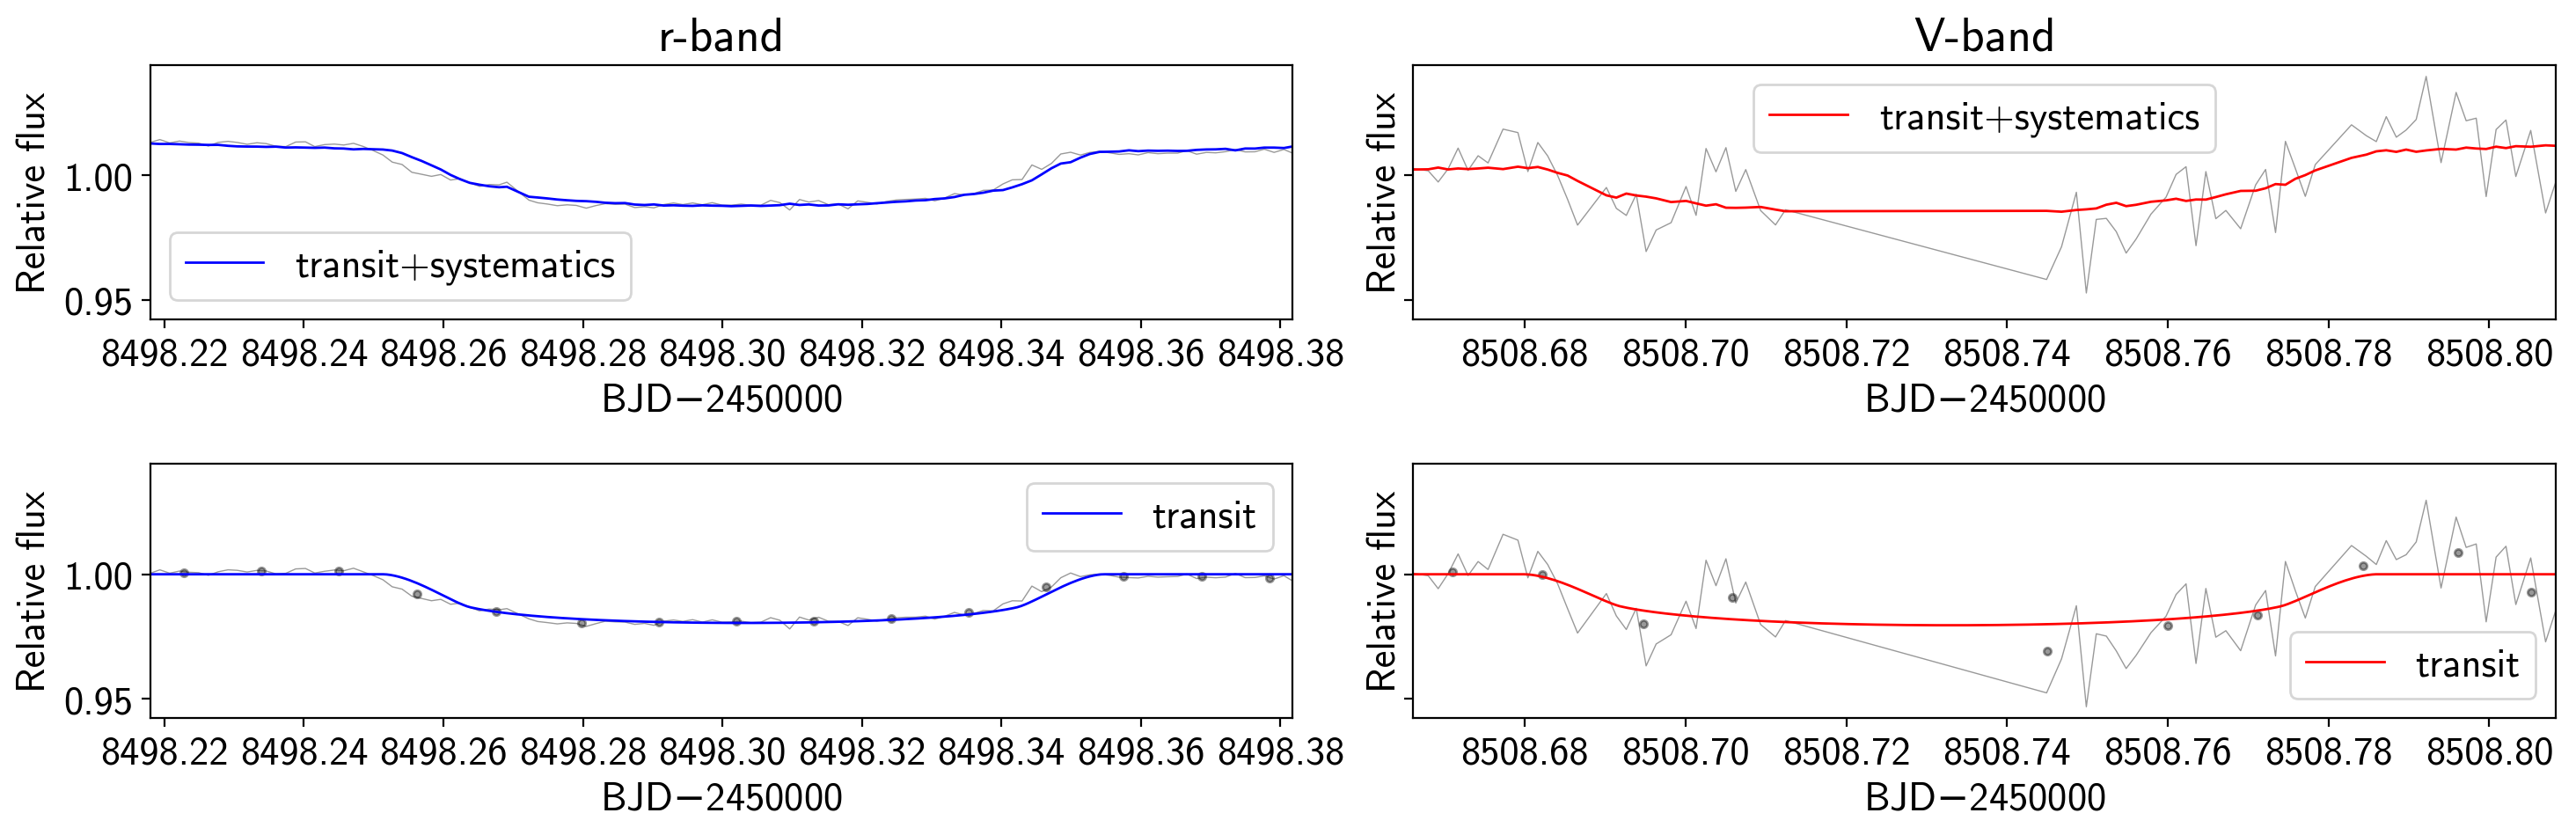

In [12]:
fig, axs = pl.subplots(2, 2, figsize=(15,5), sharex=False, sharey=True)
colors = ['b', 'r']
for i,band in enumerate(fits.keys()):
    c = colors[i]
    fits[band].plot_map(axs=axs[:,i], c1=c, c2=c)
    axs[0,i].set_title('{}-band'.format(band))
    
fig.tight_layout()

In [13]:
for band in fits.keys():
    print("\n{:*^30s}".format(band+'-band'))
    fits[band].fit_mcmc(two_stage=True, steps=100, nproc=4)


************r-band************
Running stage 1 MCMC (250 steps)...


../transitfit/model.py:65: RuntimeWarning: divide by zero encountered in log
  lp += np.log(stats.norm.pdf(p, loc=pp[0], scale=pp[1]))
../transitfit/model.py:65: RuntimeWarning: divide by zero encountered in log
  lp += np.log(stats.norm.pdf(p, loc=pp[0], scale=pp[1]))
../transitfit/model.py:65: RuntimeWarning: divide by zero encountered in log
  lp += np.log(stats.norm.pdf(p, loc=pp[0], scale=pp[1]))
../transitfit/model.py:65: RuntimeWarning: divide by zero encountered in log
  lp += np.log(stats.norm.pdf(p, loc=pp[0], scale=pp[1]))


Running production MCMC for 100 steps...
[[Variables]]
    t0:   2.4571e+06 +/- 0.001155 (0.00%) (init= 2457142)
    p:    3.47663169 +/- 3.66e-06 (0.00%) (init= 3.476643)
    k:    0.12705583 +/- 0.000809 (0.64%) (init= 0.126)
    a:    11.9182945 +/- 0.002066 (0.02%) (init= 11.77354)
    b:    0.08058475 +/- 0.002089 (2.59%) (init= 0.2573653)
    q1:   0.52307000 +/- 0.001800 (0.34%) (init= 0.5129424)
    q2:   0.34440720 +/- 0.002536 (0.74%) (init= 0.3541608)
    ls:  -6.78919879 +/- 0.001160 (0.02%) (init=-6.307266)
    c0:   8.61110369 +/- 0.001314 (0.02%) (init= 8.612654)
    c1:  -0.09178637 +/- 0.001724 (1.88%) (init=-0.1100351)
    c2:   0.46020368 +/- 0.001742 (0.38%) (init= 0.6591836)
    c3:  -6.88471736 +/- 0.002128 (0.03%) (init=-6.544662)
    c4:  -1.71304676 +/- 0.001354 (0.08%) (init=-2.055472)
None
FIT_MCMC elapsed time: 41 sec

************V-band************
Running stage 1 MCMC (250 steps)...


/home/jp/miniconda3/envs/py3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/jp/miniconda3/envs/py3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Running production MCMC for 100 steps...
[[Variables]]
    t0:   2.4571e+06 +/- 0.001227 (0.00%) (init= 2457142)
    p:    3.47663760 +/- 1.05e-05 (0.00%) (init= 3.476643)
    k:    0.14441989 +/- 0.003818 (2.64%) (init= 0.126)
    a:    11.5949273 +/- 0.003326 (0.03%) (init= 11.77354)
    b:    0.02284729 +/- 0.004044 (17.70%) (init= 7.489171e-08)
    q1:   0.57930464 +/- 0.006080 (1.05%) (init= 0.5826269)
    q2:   0.39489465 +/- 0.005117 (1.30%) (init= 0.3903446)
    ls:  -4.33532594 +/- 0.006122 (0.14%) (init=-4.362325)
    c0:   0.01246151 +/- 0.003054 (24.51%) (init= 0.007062569)
    c1:   0.00671723 +/- 0.004266 (63.52%) (init= 0.05004082)
    c2:  -0.00284650 +/- 0.003072 (107.95%) (init=-0.003737397)
None
FIT_MCMC elapsed time: 41 sec



************r-band************

************V-band************


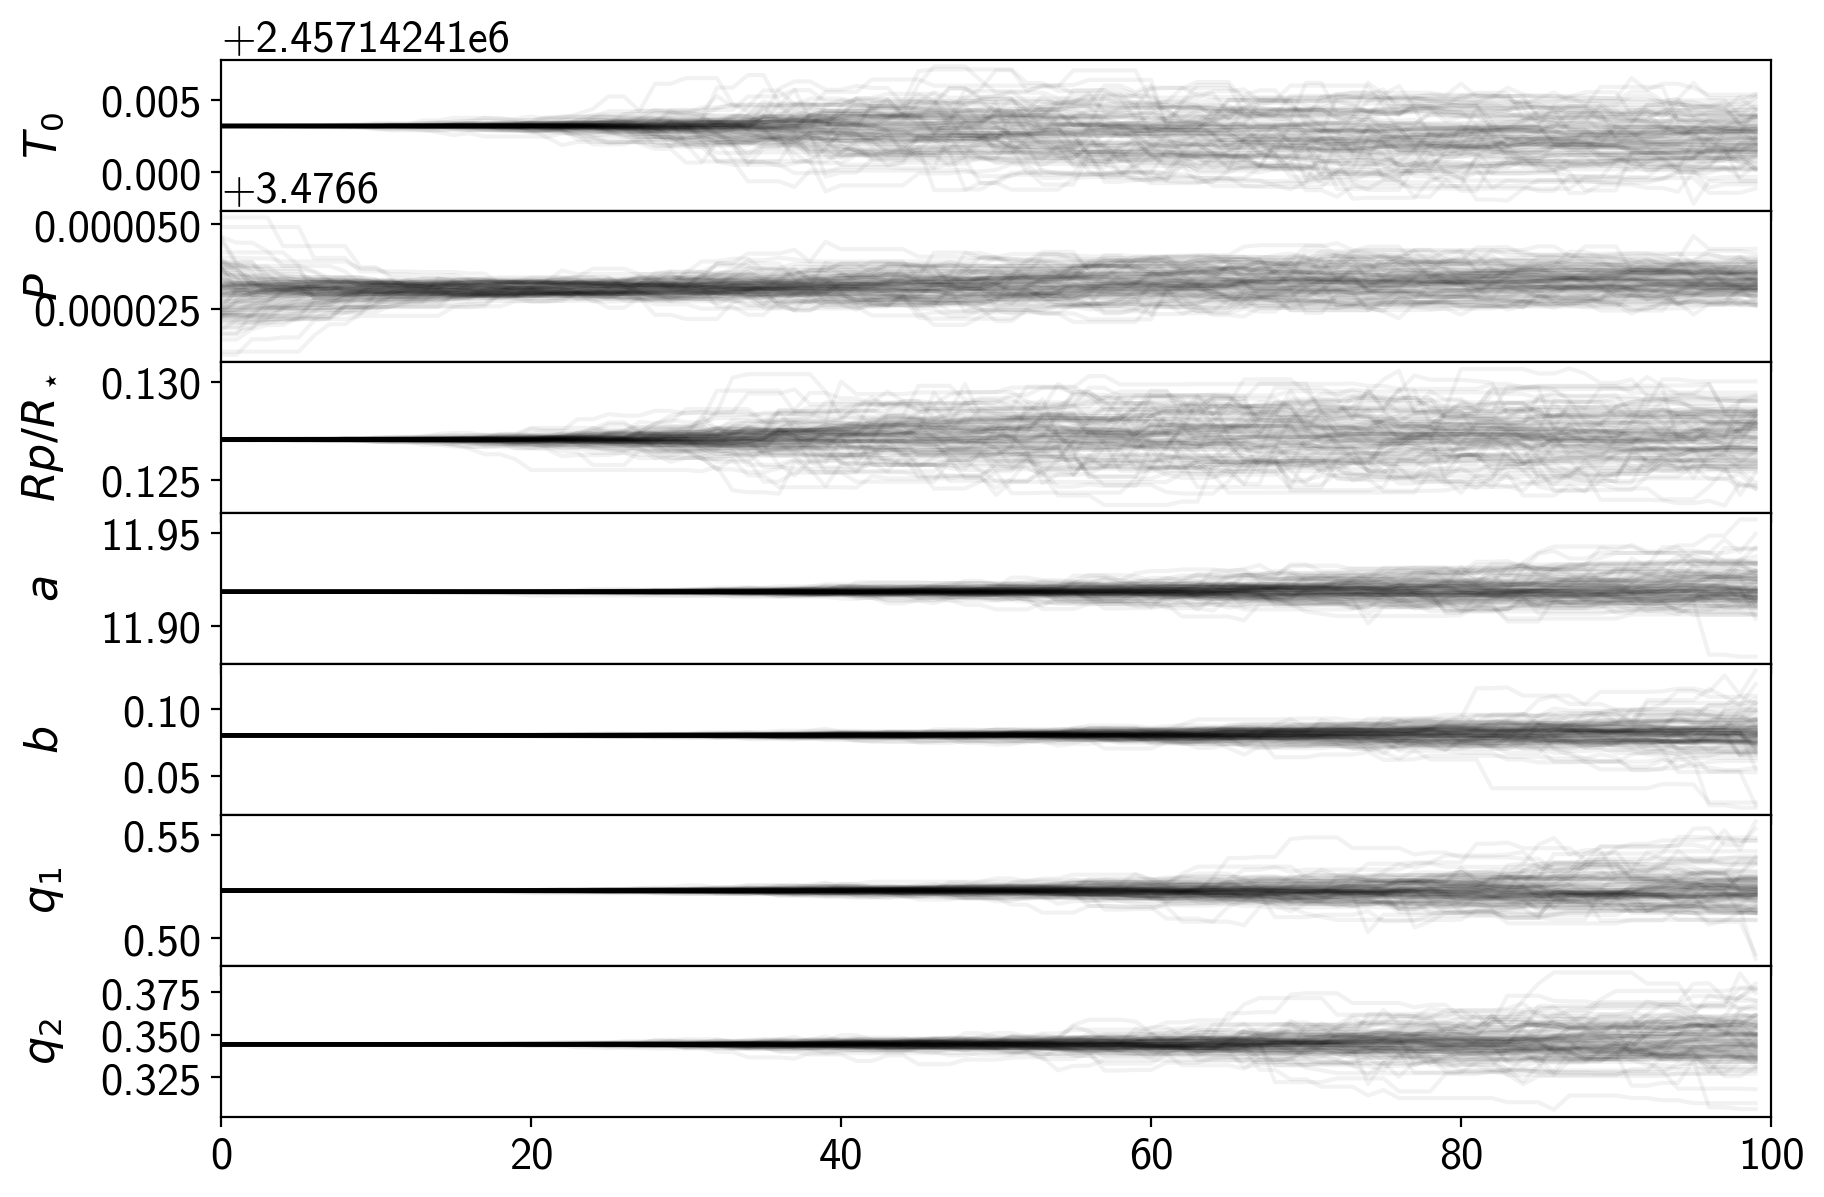

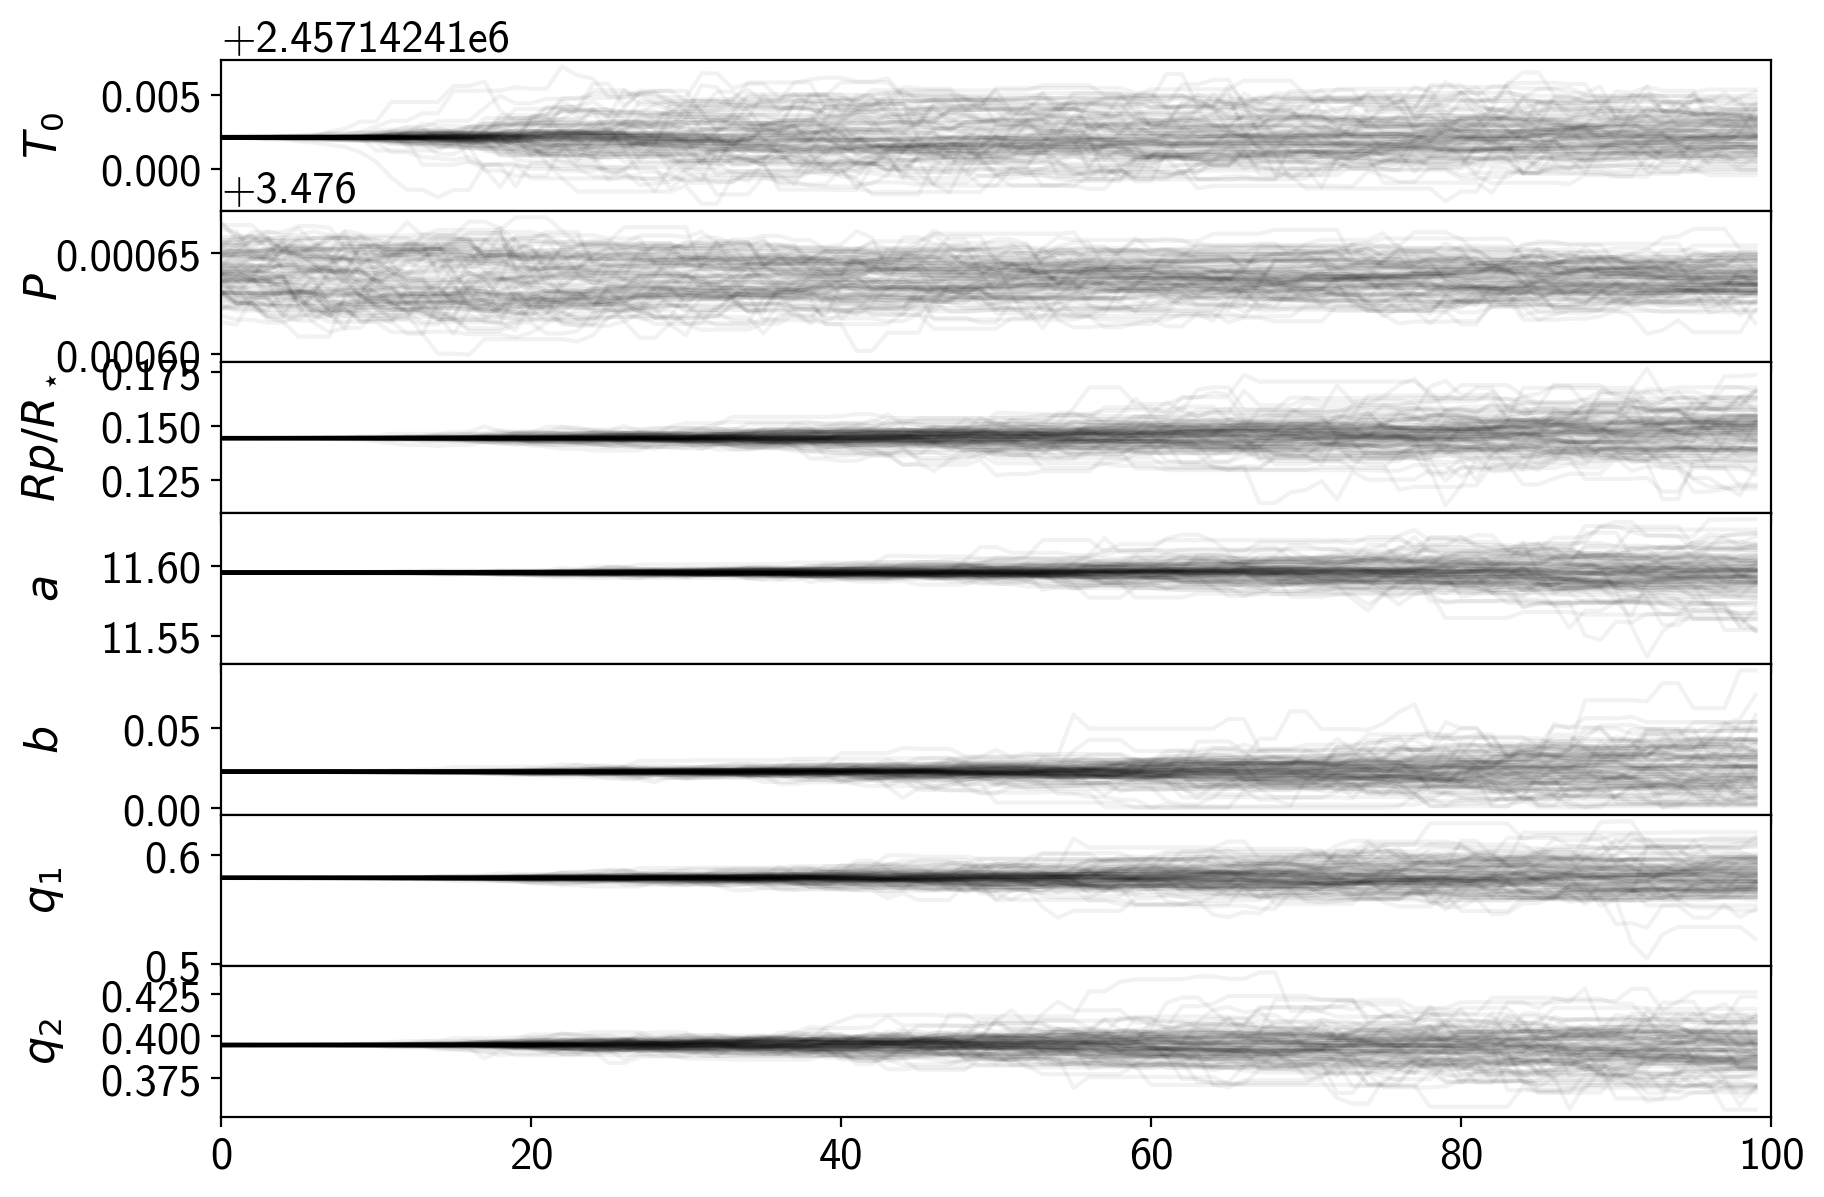

In [14]:
for band in fits.keys():
    print("\n{:*^30s}".format(band+'-band'))
    fits[band].plot_trace()


************r-band************

************V-band************


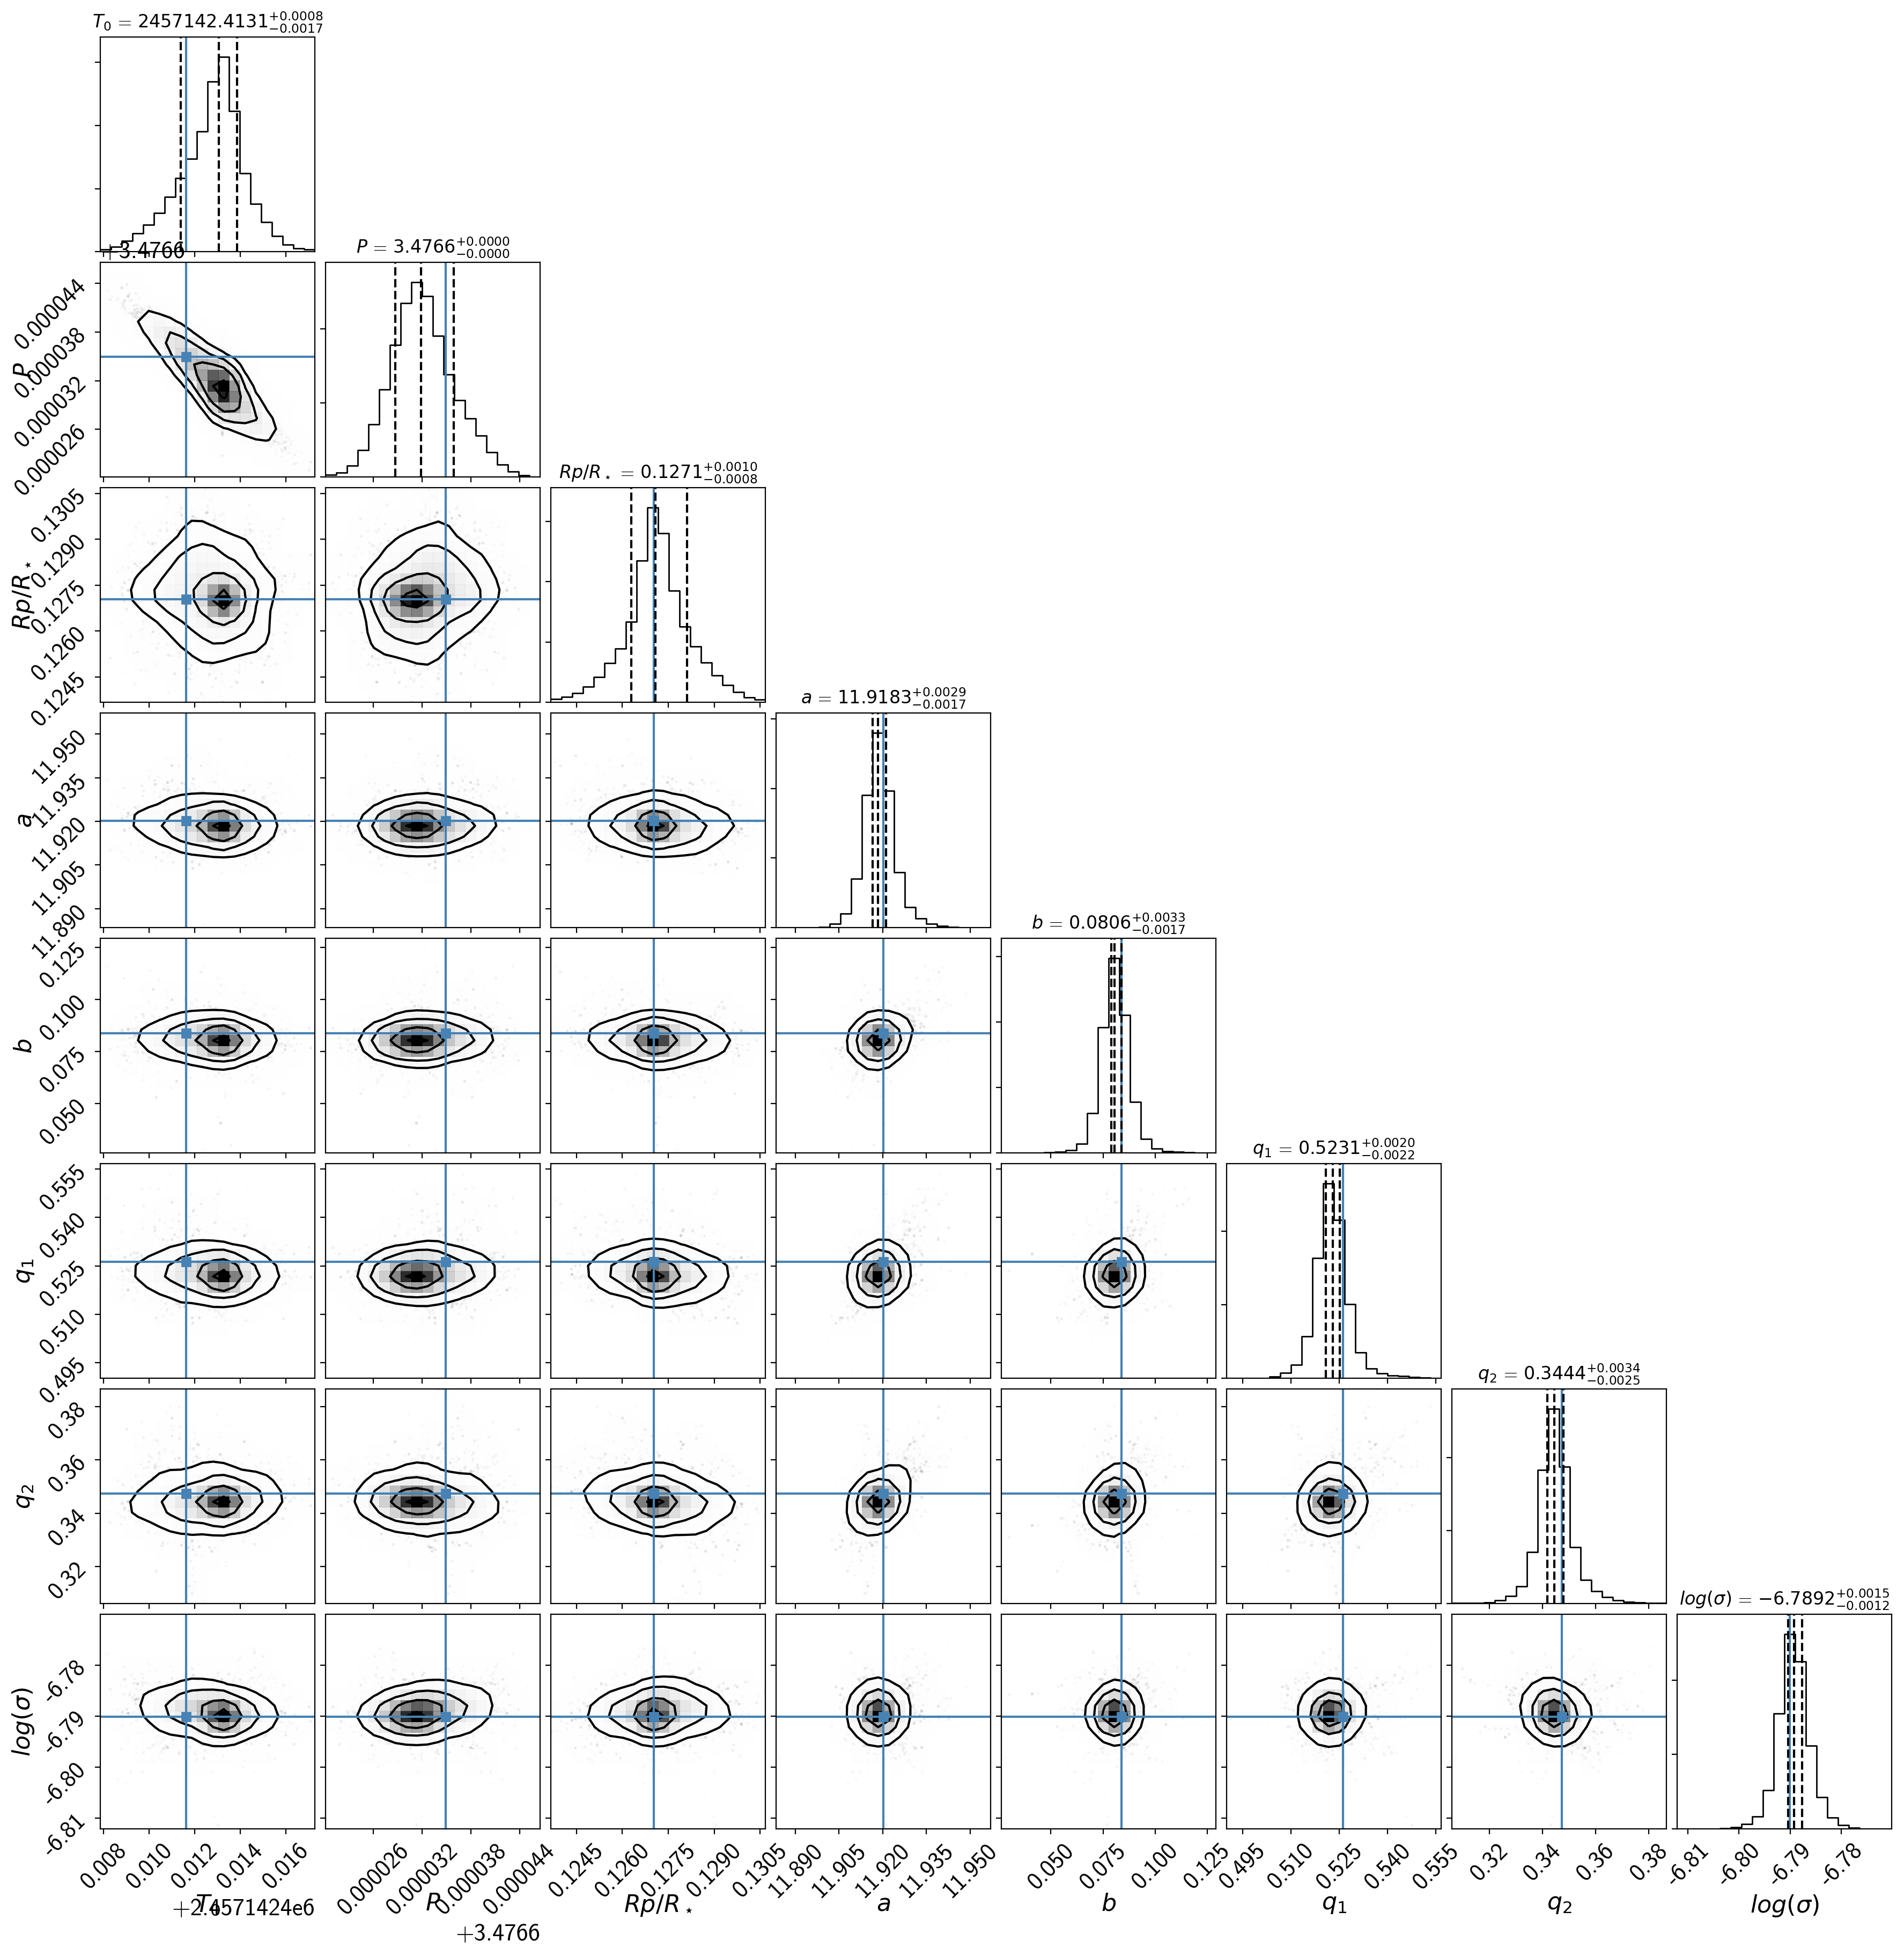

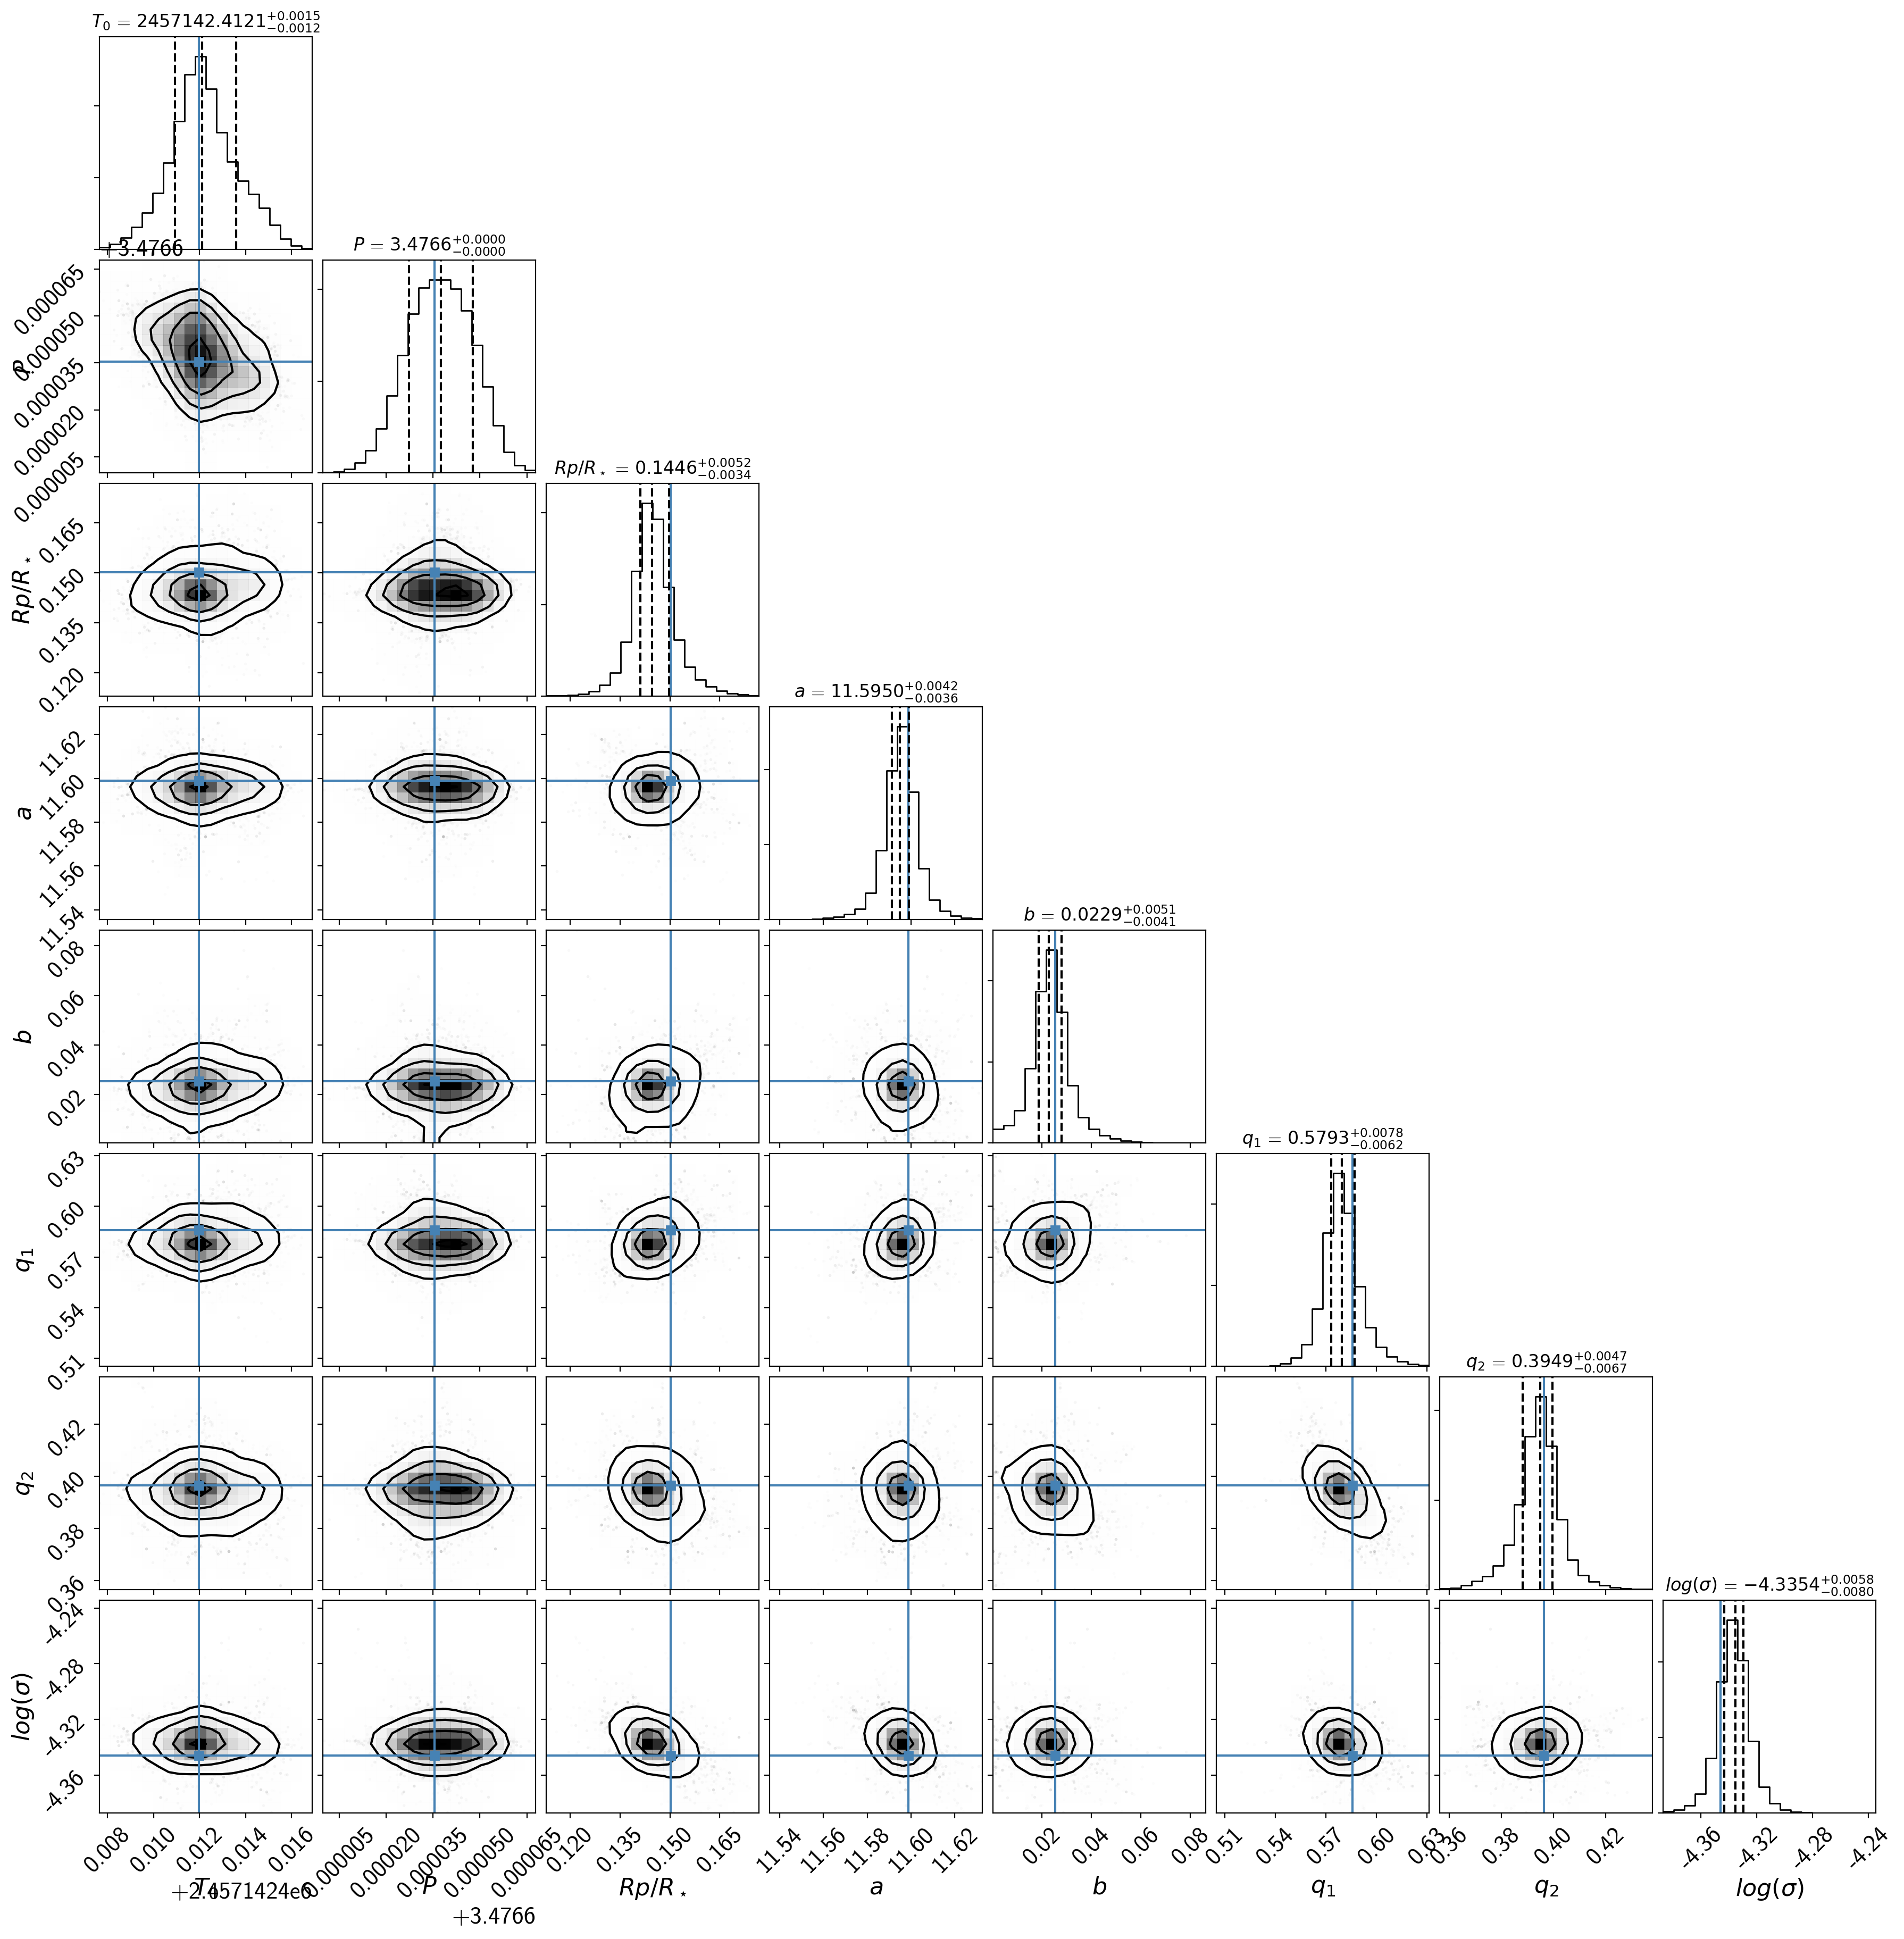

In [15]:
for band in fits.keys():
    print("\n{:*^30s}".format(band+'-band'))
    fits[band].burn_thin(burn=10, thin=1)
    fits[band].plot_corner()

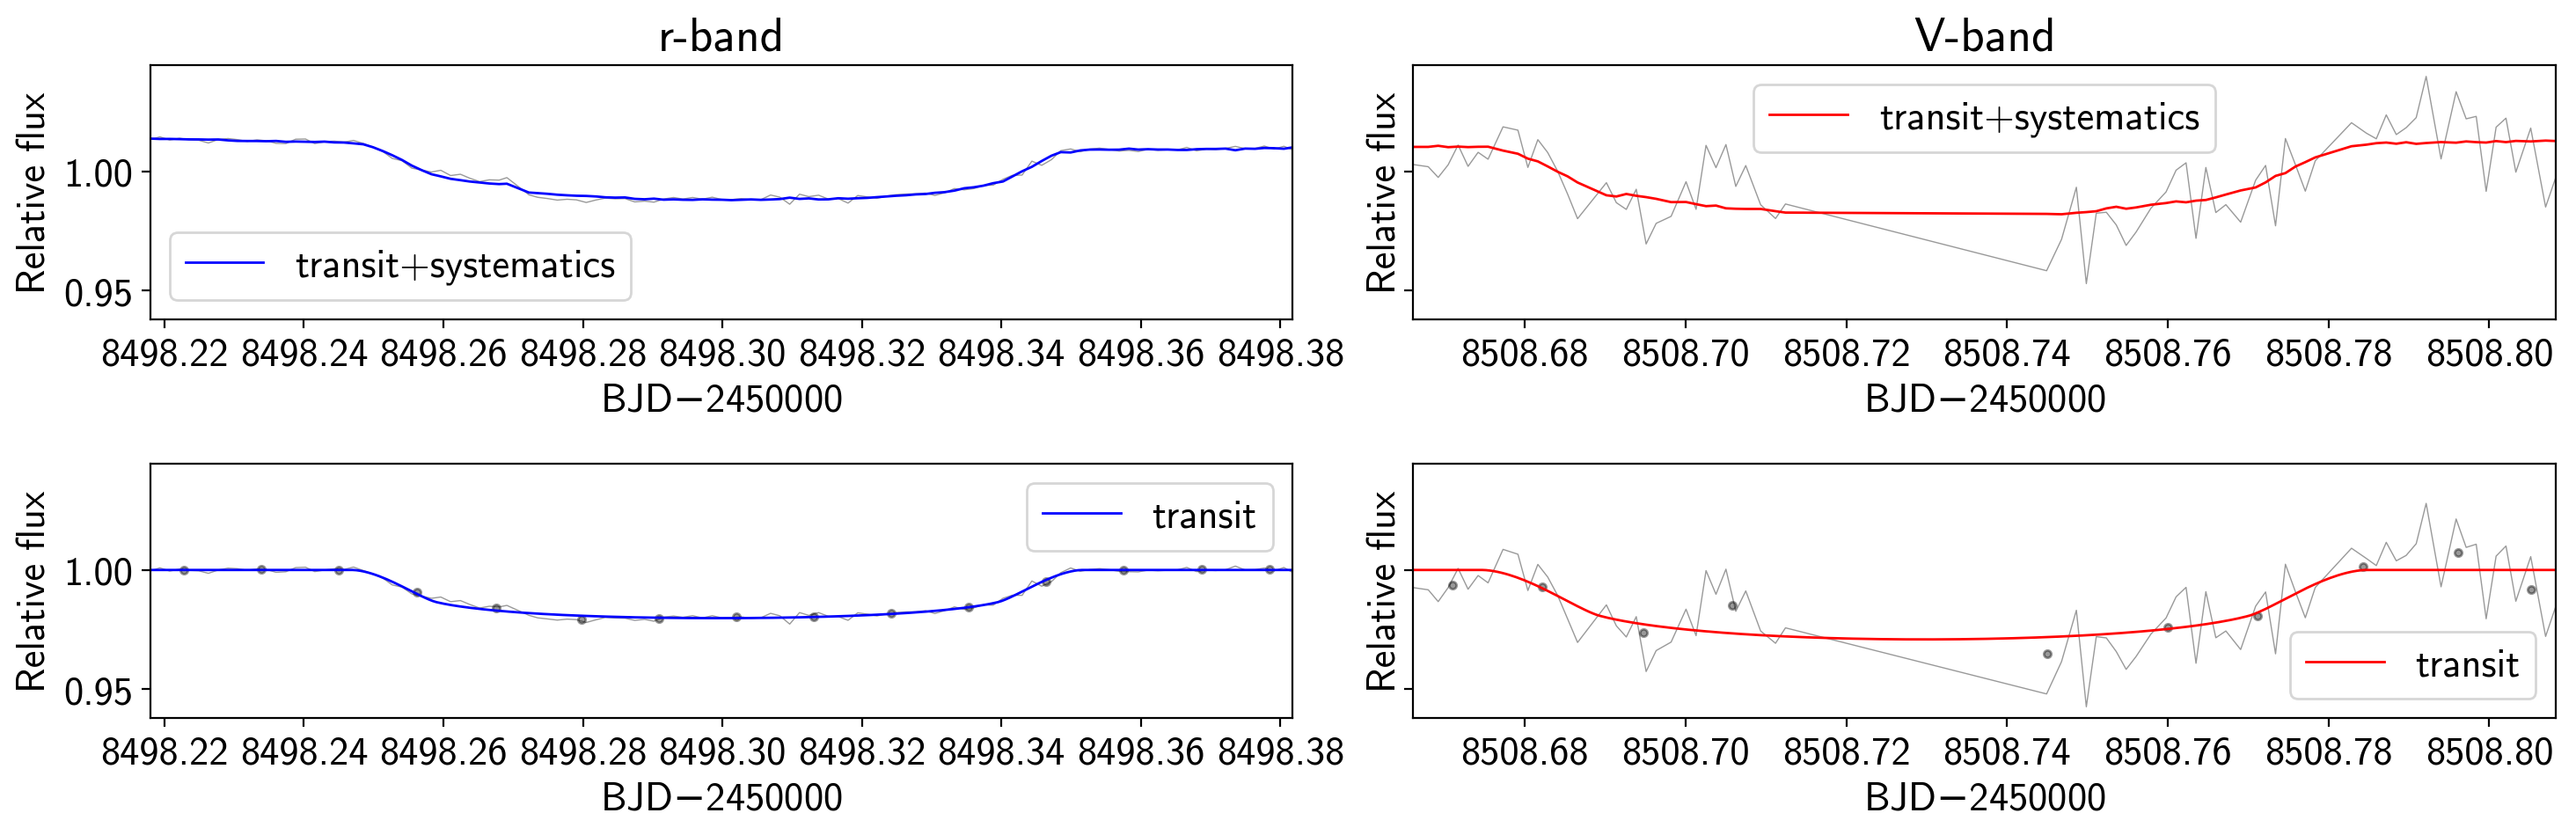

In [16]:
fig, axs = pl.subplots(2, 2, figsize=(15,5), sharex=False, sharey=True)
colors = ['b', 'r']
for i,band in enumerate(fits.keys()):
    c = colors[i]
    fits[band].plot_map(axs=axs[:,i], c1=c, c2=c)
    axs[0,i].set_title('{}-band'.format(band))

fig.tight_layout()

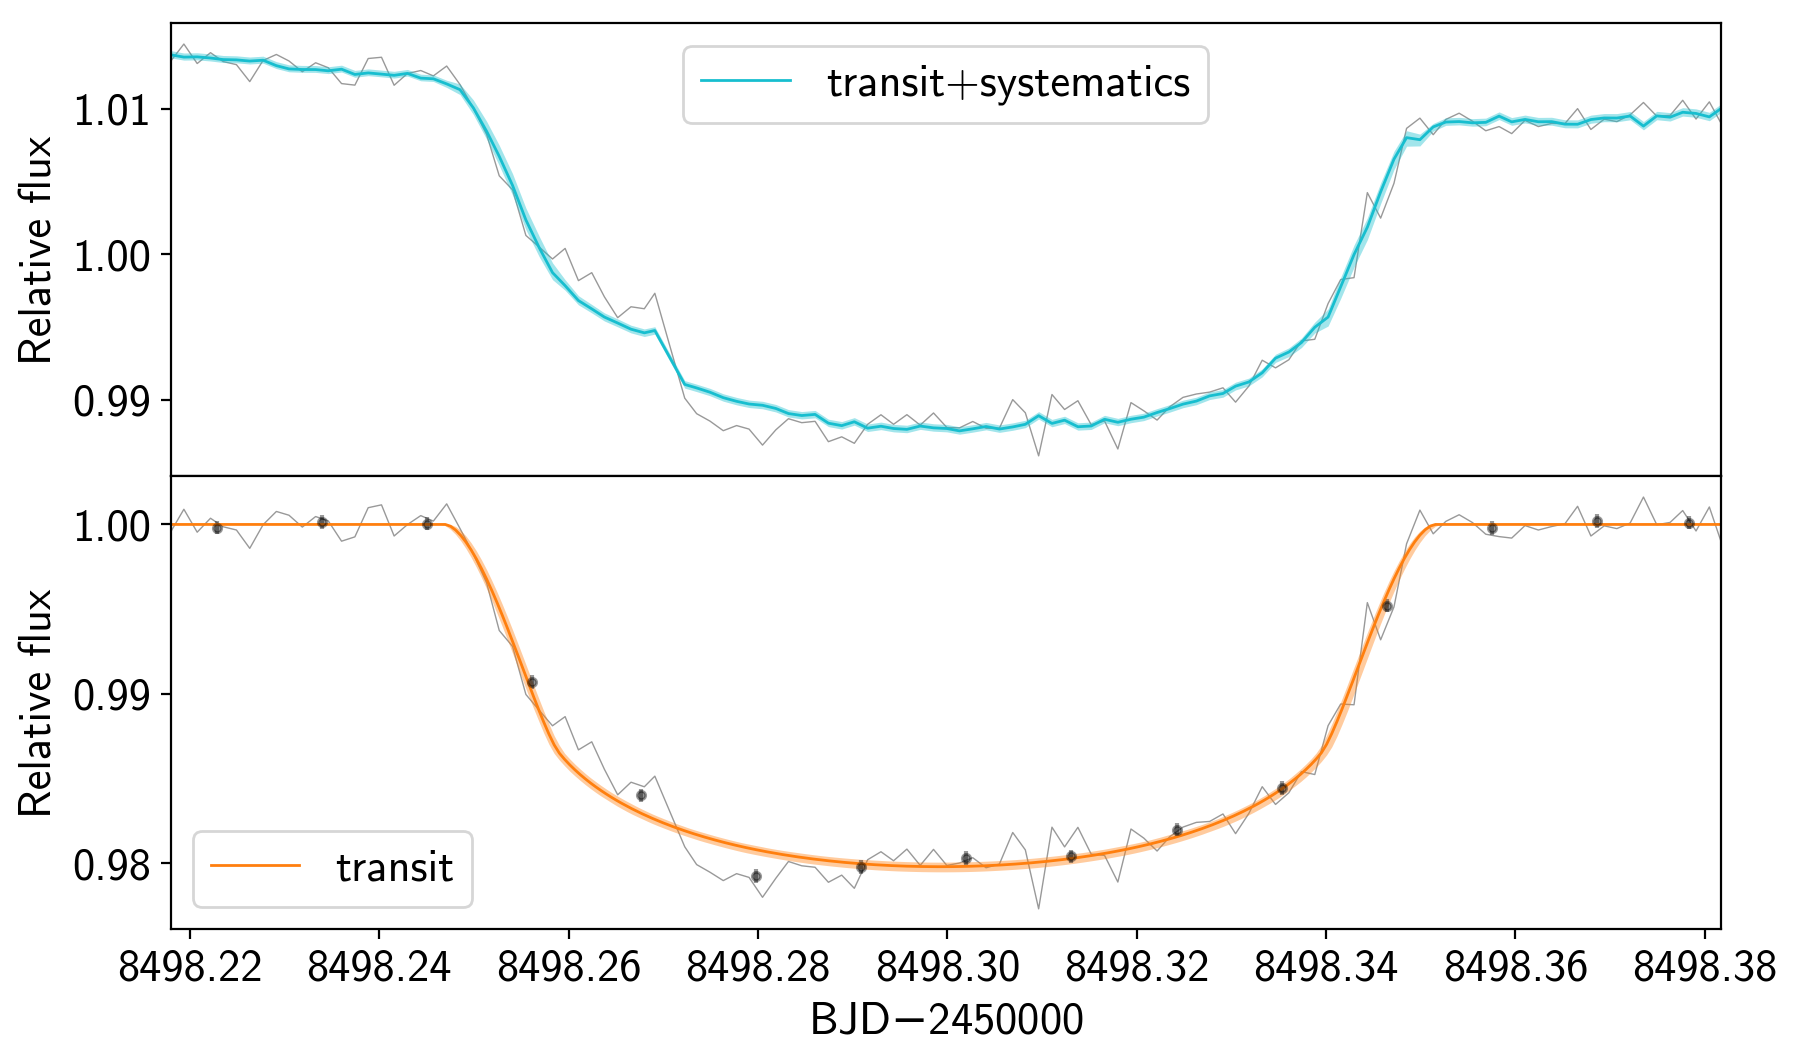

In [17]:
fits['r'].plot_mcmc(sig=1)

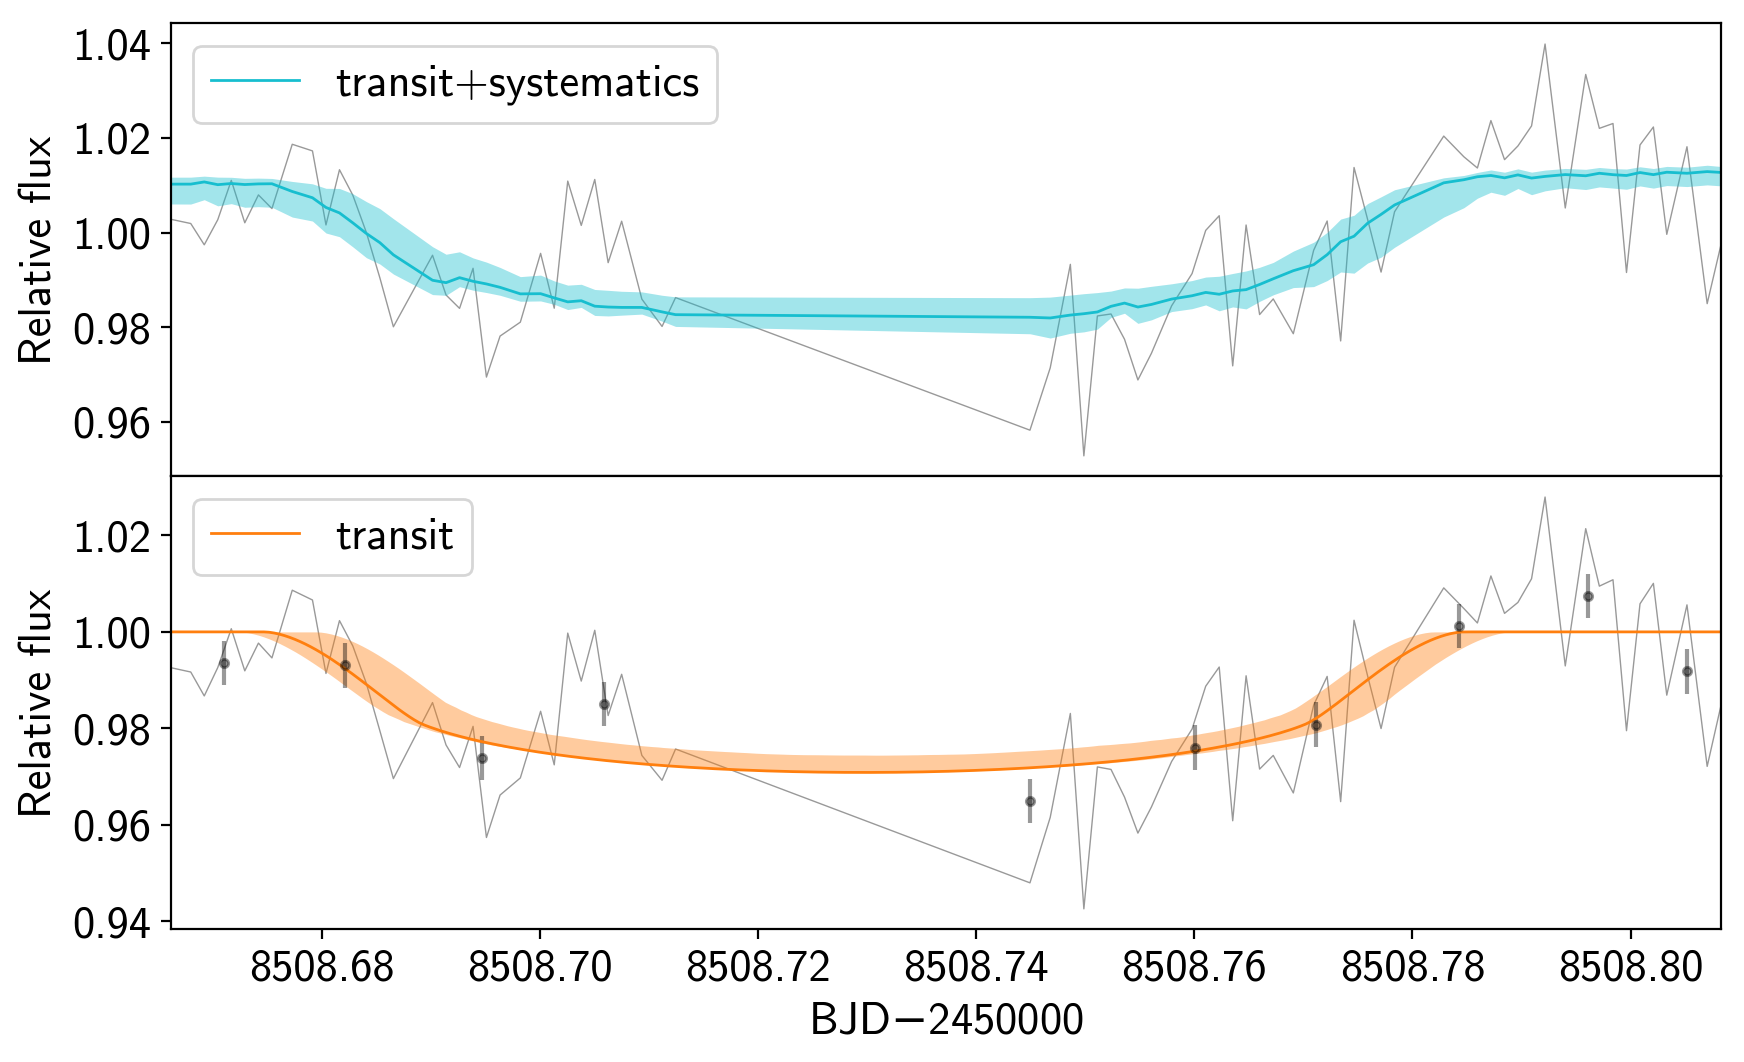

In [18]:
fits['V'].plot_mcmc(sig=1)

In [19]:
rad = map_float(star['rad'])

for band,fit in fits.items():
    df = fit.get_df(*rad)
    print("\n{:*^30s}".format(band))
#     keys = 'pl_rad inc p t0 t14 t23 shape k max_k rhostar'.split()
    keys = 'pl_rad inc p t0 t14 t23 shape k max_k'.split()
    for key in keys:
        mu, sig = df[key].median(), df[key].std()
        print('{0: >8}: {1:<10.4f} +/- {2:<10.4f}'.format(key, mu, sig))


**************r***************
  pl_rad: 11.7804    +/- 0.2918    
     inc: 89.6124    +/- 0.0260    
       p: 3.4766     +/- 0.0000    
      t0: 2457142.4131 +/- 0.0013    
     t14: 0.1045     +/- 0.0001    
     t23: 0.0808     +/- 0.0001    
   shape: 0.7727     +/- 0.0016    
       k: 0.1271     +/- 0.0010    
   max_k: 0.1282     +/- 0.0010    

**************V***************
  pl_rad: 13.4368    +/- 0.6396    
     inc: 89.8870    +/- 0.0370    
       p: 3.4766     +/- 0.0000    
      t0: 2457142.4121 +/- 0.0014    
     t14: 0.1094     +/- 0.0006    
     t23: 0.0817     +/- 0.0006    
   shape: 0.7467     +/- 0.0092    
       k: 0.1446     +/- 0.0060    
   max_k: 0.1450     +/- 0.0060    


In [32]:
import lmfit
from emcee.utils import sample_ball
from transitfit.util import timeit

def get_par(fits):
    par = lmfit.Parameters()

    map_par = list(fits.values())[0].map_par.copy()
    shared_names = 'p a'.split()
    for na in shared_names:
        k = na + '_s'
        par[k] = map_par[na]

    for band,fit in fits.items():
        map_par = fit.map_par.copy()
        for key in map_par.valuesdict().keys():
            if key not in shared_names:
                k = key + '_{}'.format(band)
                par[k] = map_par[key]
    return par

def log_probability(par, fits):

    p = par.copy()
    lp = 0
    for band,fit in fits.items():
        par = fit.map_par.copy()
        for key in par.valuesdict().keys():
            if key.endswith('_s'):
                k = key.replace('_s','')
                par[k] = p[key]
            elif key.endswith('_{}'.format(band)):
                k = key.replace('_{}'.format(band),'')
                par[k] = p[key]
        lp += fit.log_probability(par)
            
    return lp if np.isfinite(lp) else -np.inf

@timeit
def run_mcmc(par, fits, steps=1000):
    args = (fits,)
#     mini = lmfit.Minimizer(log_probability, par, fcn_args=args, nan_policy='omit')
    mini = lmfit.Minimizer(log_probability, par, fcn_args=args)

    theta = [v for k,v in par.items() if par[k].vary]
    ndim = len(theta)
    nwalkers = 100
    pos0 = sample_ball(theta, [1e-5]*ndim, nwalkers)
    res = mini.emcee(burn=0, steps=steps, thin=1, pos=pos0, workers=1)
    
    return res

par = get_par(fits)
# par'p_s'].vary = False
log_probability(par, fits)

906.6156270657357

In [33]:
%timeit log_probability(par, fits)

6.45 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
# steps = 1500
# burn = 1000
steps = 100
burn = 50
# steps = 500
# burn = 250
thin = 1

res = run_mcmc(par, fits, steps=steps)
print(lmfit.fit_report(res.params, show_correl=False))

RUN_MCMC elapsed time: 41 sec
[[Variables]]
    p_s:    3.47658080 +/- 0.108274 (3.11%) (init= 3.476635)
    a_s:    11.9202210 +/- 0.498764 (4.18%) (init= 11.92027)
    t0_r:   2.4571e+06 +/- 0.158557 (0.00%) (init= 2457142)
    k_r:    0.12738089 +/- 0.048005 (37.69%) (init= 0.1270353)
    b_r:    0.08500445 +/- 0.051894 (61.05%) (init= 0.08373552)
    q1_r:   0.52614086 +/- 0.108040 (20.53%) (init= 0.5261896)
    q2_r:   0.34737021 +/- 0.016080 (4.63%) (init= 0.3473335)
    ls_r:  -6.79055173 +/- 0.085586 (1.26%) (init=-6.790112)
    c0_r:   8.61012271 +/- 0.428648 (4.98%) (init= 8.610067)
    c1_r:  -0.09196374 +/- 0.066800 (72.64%) (init=-0.09227022)
    c2_r:   0.46251049 +/- 0.058773 (12.71%) (init= 0.4619505)
    c3_r:  -6.88368651 +/- 0.099004 (1.44%) (init=-6.883716)
    c4_r:  -1.71297132 +/- 0.227052 (13.25%) (init=-1.713038)
    t0_V:   2.4571e+06 +/- 0.155101 (0.00%) (init= 2457142)
    k_V:    0.15011850 +/- 0.079202 (52.76%) (init= 0.1501895)
    b_V:    0.02539944 +/- 

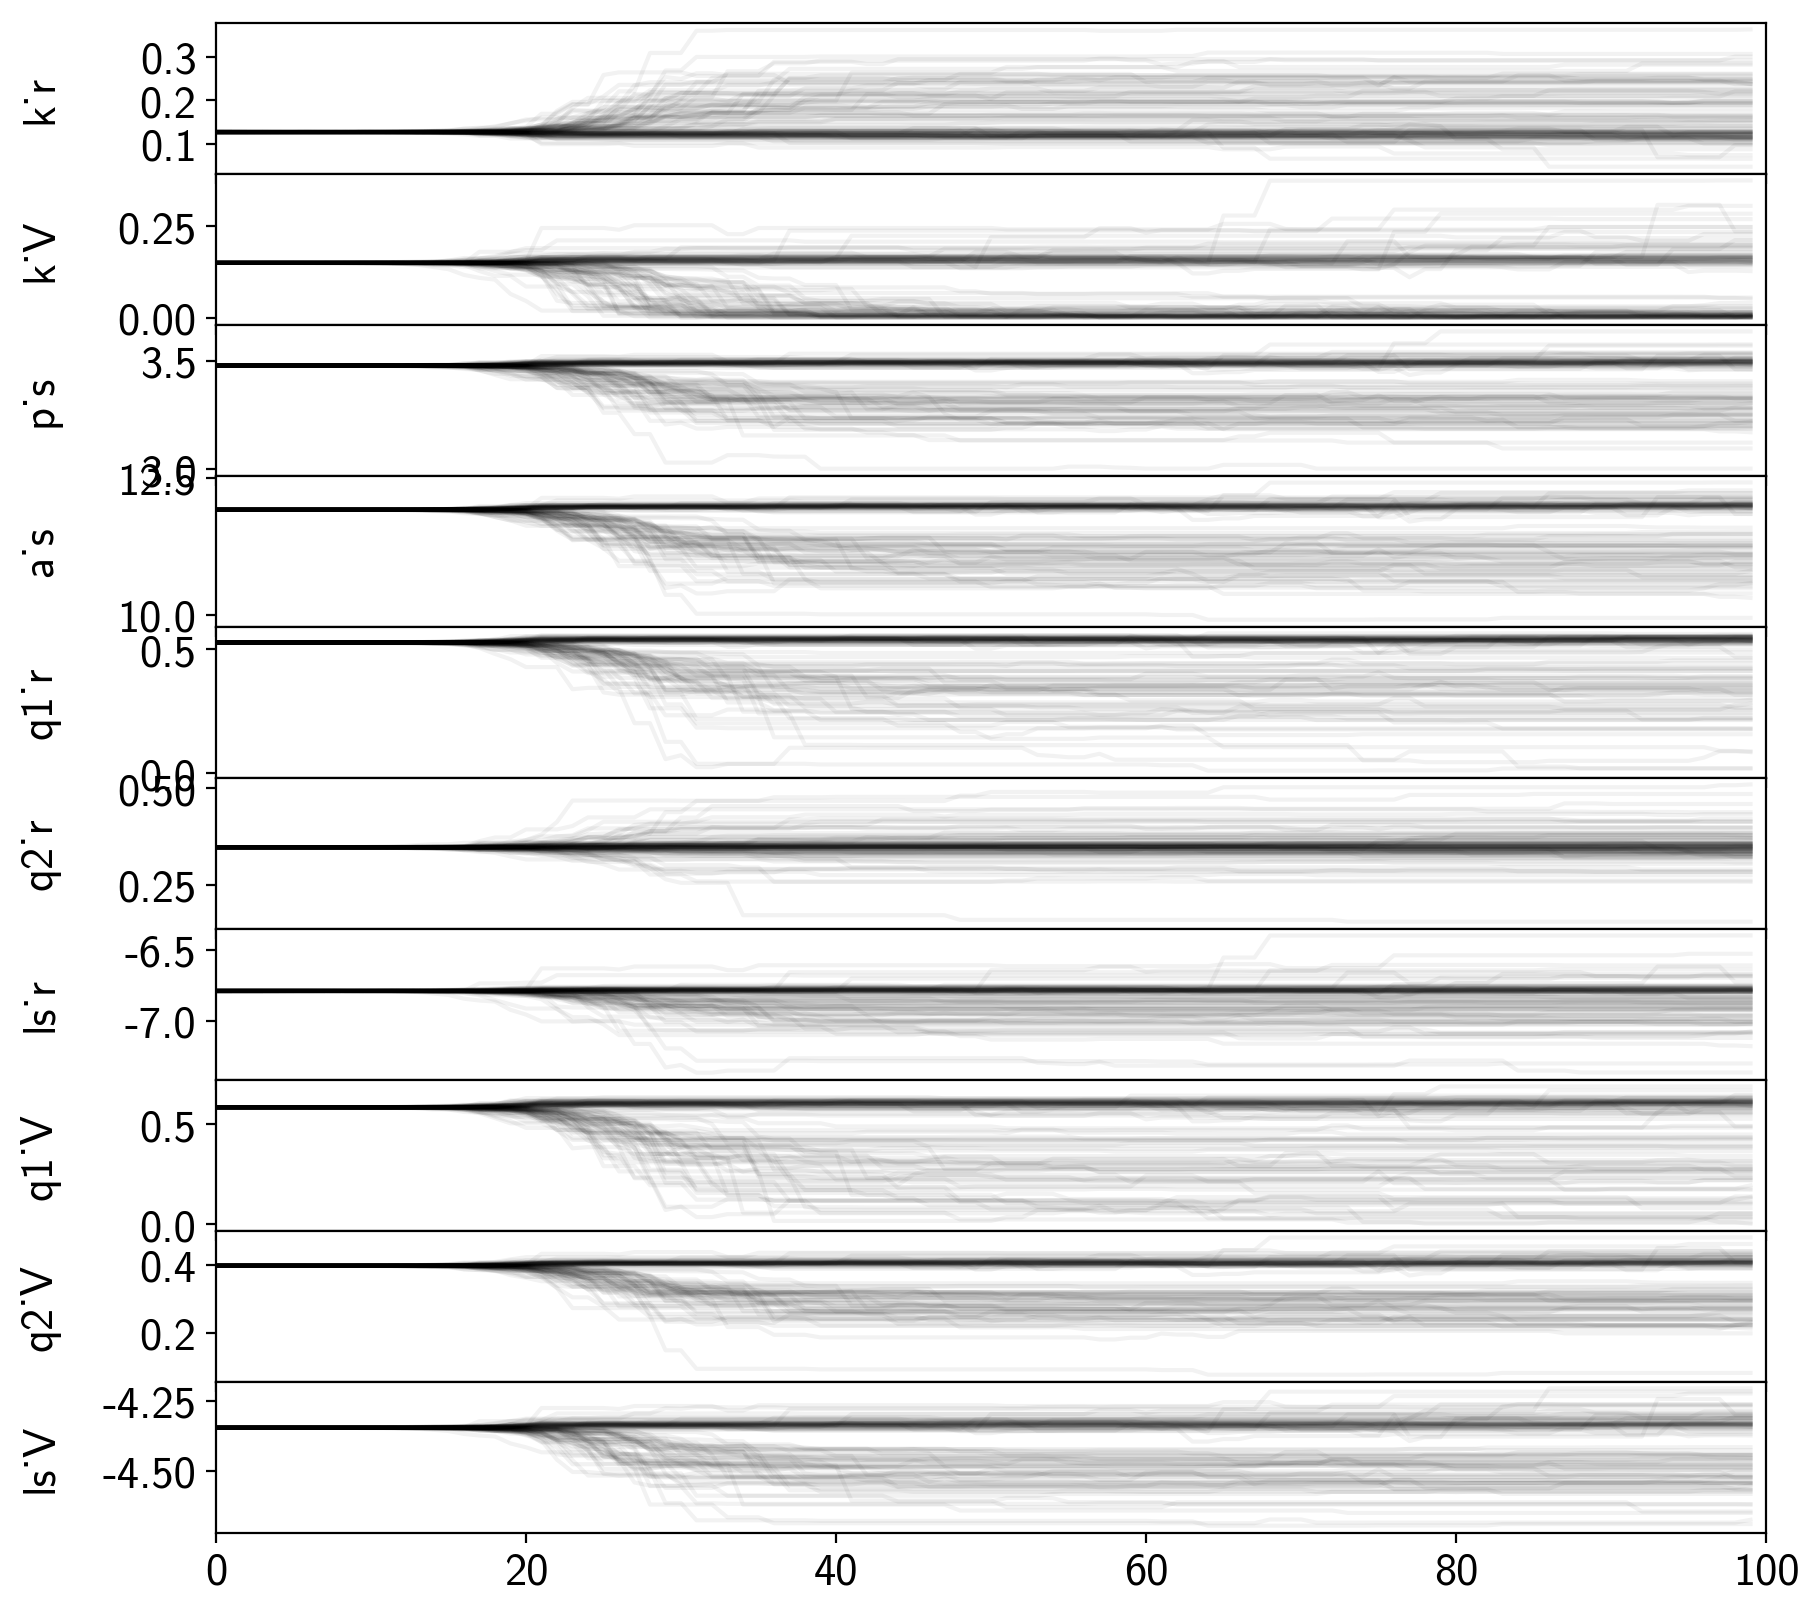

In [35]:
from transitfit.plot import plot_trace
par_names = [k for k,v in par.valuesdict().items() if par[k].vary]

plot_idx = []

for band in fits.keys():
    plot_idx.append(par_names.index('k_{}'.format(band)))

shared = 'p t0 a b'.split()
for pn in shared:
    tn = pn+'_s'
    if tn in par_names:
        plot_idx.append(par_names.index(tn))

for band in fits.keys():
    plot_idx.append(par_names.index('q1_{}'.format(band)))
    plot_idx.append(par_names.index('q2_{}'.format(band)))
    plot_idx.append(par_names.index('ls_{}'.format(band)))

plot_names = np.array(par_names)[plot_idx]
plot_trace(res.chain, plot_names, plot_idx=plot_idx, fp=None)

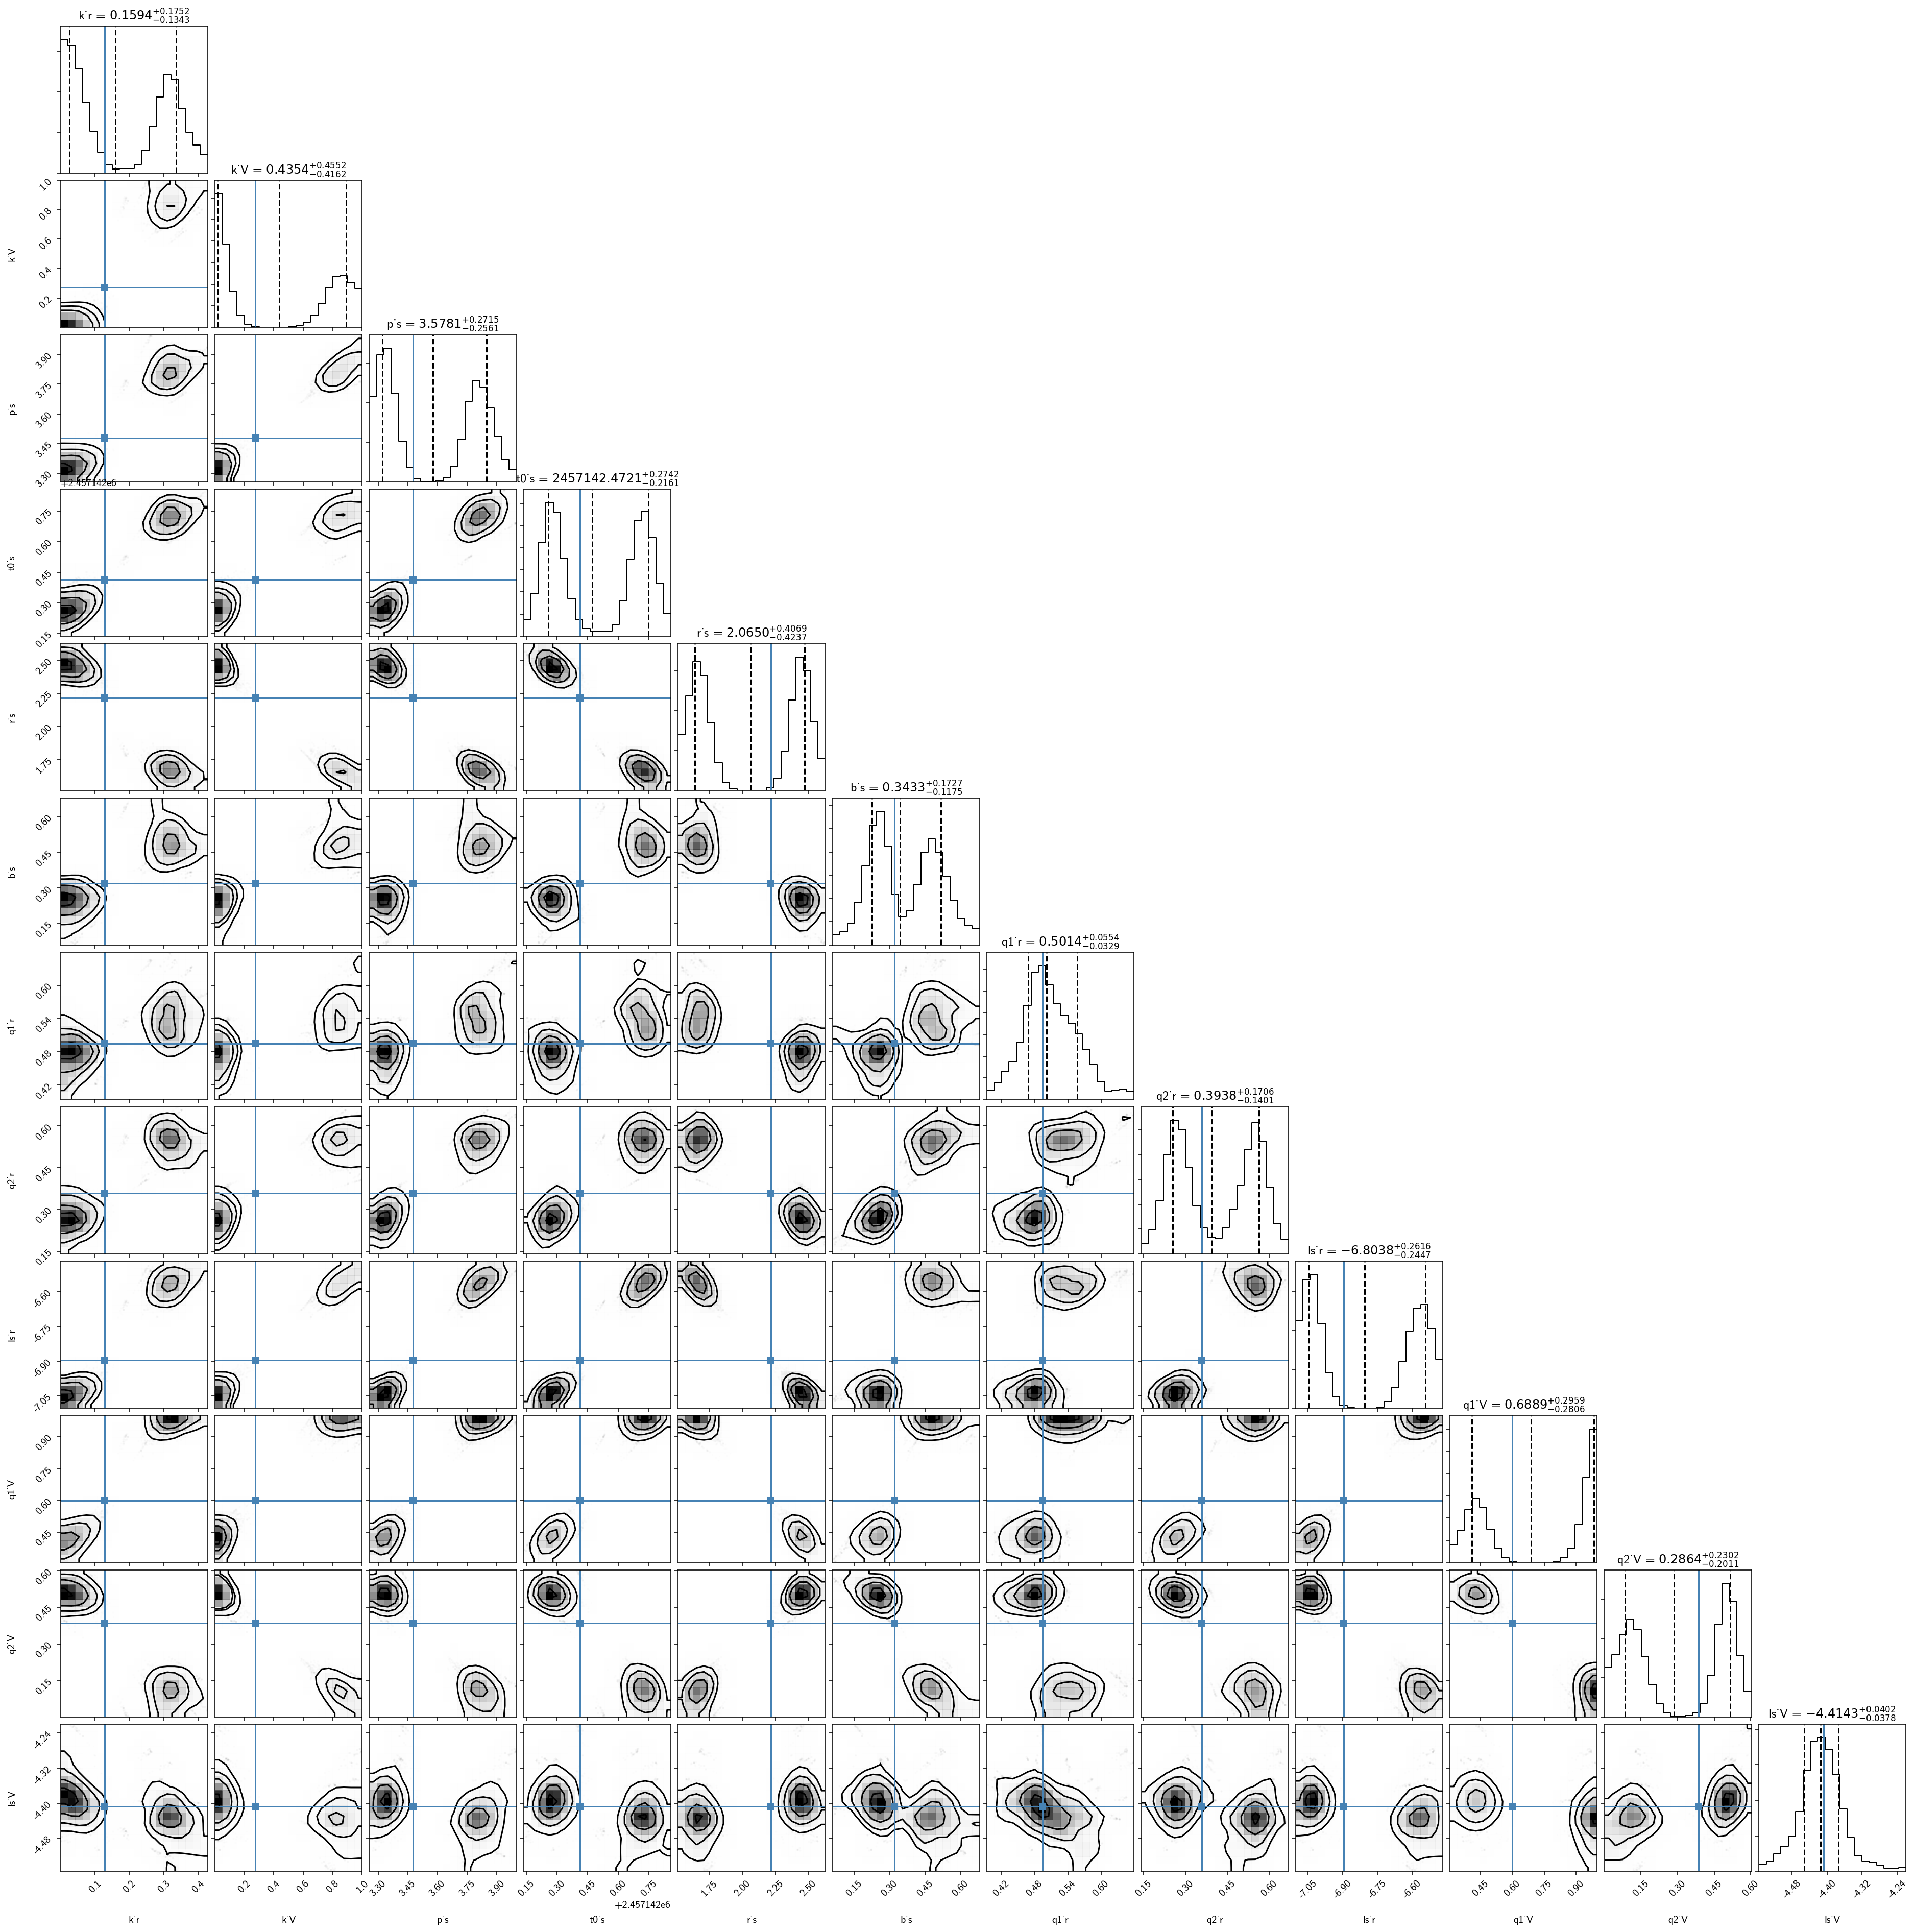

In [66]:
from transitfit.plot import plot_corner

highest_prob = np.argmax(res.lnprob)
hp_loc = np.unravel_index(highest_prob, res.lnprob.shape)
best = res.chain[hp_loc]

nwalkers, nsteps, ndim = res.chain.shape
fc = res.chain[:,burn::thin,:].reshape(-1, ndim)

plot_corner(fc[:,plot_idx], best[plot_idx], np.array(par_names)[plot_idx])

In [47]:
def update_fit(fits, par, fc, best):

    par_names = [k for k,v in par.valuesdict().items() if par[k].vary]
#     shared_names = [pn for pn in par_names if pn.endswith('_s')]

    for band,fit in fits.items():
        # order needs to match the order of parameters in an individual fit
        idx = [par_names.index('t0_s')]
        idx.append(par_names.index('p_s'))
#         idx.append(par_names.index('k_{}'.format(i)))
        idx.append(par_names.index('k_s'))
        idx.append(par_names.index('a_s'))
        idx.append(par_names.index('b_s'))
        idx.append(par_names.index('q1_{}'.format(band)))
        idx.append(par_names.index('q2_{}'.format(band)))
        idx.append(par_names.index('ls_{}'.format(band)))
        # now get the systematics coeffs
        for pn in fit.sm.parameter_names:
            idx.append(par_names.index(pn+'_{}'.format(band)))
        
        fit.fc = fc[:,idx]
        fit.best = best[idx]
        for ix in idx:
            pn = par_names[ix].replace('_s','').replace('_{}'.format(band),'')
            fit.map_par[pn].value = best[ix]

update_fit(fits, par, fc, best)

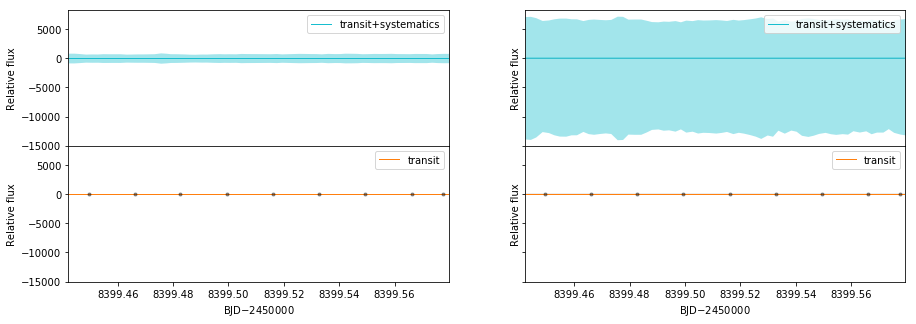

In [48]:
fig, axs = pl.subplots(2, 2, figsize=(15,5), sharex=True, sharey=True)
for i,band in enumerate(fits.keys()):
    fits[band].plot_mcmc(axs=axs[:,i])

In [64]:
rad = map_float(star['rad'])

for band,fit in fits.items():
    df = fit.get_df(*rad)
    print("\n{:*^30s}".format(band))
    for key in 'pl_rad inc p t0 t14 t23 shape k max_k rhostar'.split():
        mu, sig = df[key].median(), df[key].std()
        print('{0: >8}: {1:<10.4f} +/- {2:<10.4f}'.format(key, mu, sig))

NameError: name 'pd' is not defined